# <center>House Prices</center>
With explanatory variables describing (almost) every aspect of residential homes in Ames, lowa. Using this dataset predict the final price of each home.

In [352]:
# Code for showing toggle button for showing/hiding the code
# While exporting this Jupyter notebook to html for presentation purpose, hide the code for analytical view
from IPython.display import HTML,Image,display
HTML('''
<script>
code_show=true;
function code_toggle(){
if (code_show){
$('div.input').hide();
$("#btn_toggle").val("Show Code");
}else{
$('div.input').show();
$("#btn_toggle").val("Hide Code");
}
code_show= !code_show;
}
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
<form action="javascript:code_toggle()">
<input style = "float:right" type="submit" id="btn_toggle" value="Hide Code">
''')


In [353]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import mlxtend
from mlxtend.preprocessing import standardize
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [354]:
#Visualization settings
sns.set_style(style='white')
sns.set(rc={
    'figure.figsize': (12,7),
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},
    font_scale=1.5)
custom_colors=["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

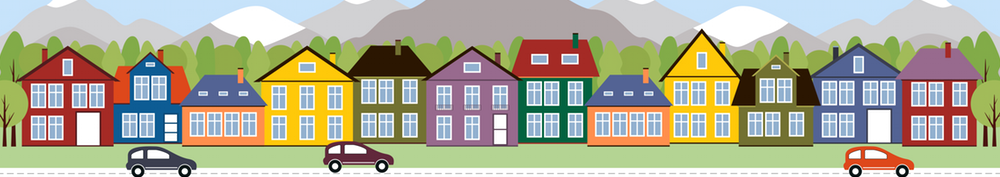

In [355]:
Image('housesbanner.png')

In [356]:
df_train=pd.read_csv('train.csv')
print ("Training data loaded")

Training data loaded


## <center>Dataset description</center>

In [357]:
print ("Sample dataframe:\n")
df_train.head(3)

Sample dataframe:



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [358]:
print (f"Initial data frame contains {df_train.shape[0]} rows and {df_train.shape[1]} columns.")

Initial data frame contains 1460 rows and 81 columns.


In [359]:
col_tags ="<ol>" + "".join([f"<li><h4>{col}</h4></li>" for col in df_train.columns]) + "</ol>"
display(HTML('<h3>Feature names:</h3>'))
display(HTML(col_tags))

In [360]:
print ("Dataset summary :\n")
df_train.info()

Dataset summary :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   in

<h3 style='background-color:yellow'>
    3 float columns <br>
    35 integer columns <br>
    43 String columns
    </h3>

In [361]:
val=df_train.isnull().sum()
df=pd.DataFrame(val,columns=["NullCount"]).query('NullCount != 0')
df=pd.DataFrame({"Features": df.index,
             "NullCount": df.NullCount.values})
df.sort_values(by="NullCount",inplace=True,ascending=False)

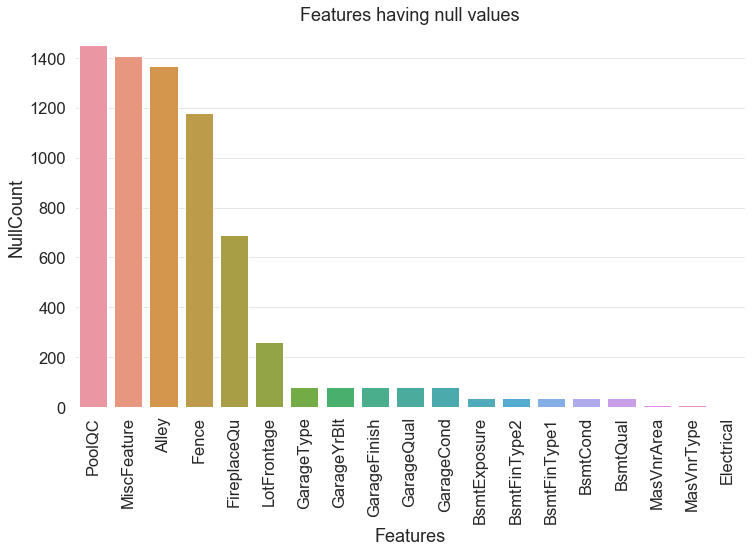

In [362]:
sns.barplot(data=df,x="Features",y="NullCount");
plt.xticks(rotation=90);
plt.title("Features having null values");

In [363]:
df

,Features,NullCount
16,PoolQC,1453
18,MiscFeature,1406
1,Alley,1369
17,Fence,1179
10,FireplaceQu,690
0,LotFrontage,259
11,GarageType,81
12,GarageYrBlt,81
13,GarageFinish,81
14,GarageQual,81


In [364]:
print (f"Number of features having null values: {df.shape[0]}")

Number of features having null values: 19


## <center> Features - Exploratory Data Analysis</center>

In [365]:
# Function for showing the statistcs and Pie chart for discrete features.
def str_discrete_analysis(fld_name):
    print ("Value counts: \n")
    print (fld_name.value_counts())
    plt.pie(fld_name.value_counts(),labels=fld_name.value_counts().index,autopct=lambda x: f'{x: .2f}%');
    plt.title(fld_name.name + " -distribution");
    print ("Null value count : ", fld_name.isnull().sum())

In [366]:
def conti_fld_analysis(fld_name):
    print (fld_name.describe())
    plt.subplot(2,2,1)
    plt.hist(fld_name)
    plt.subplot(2,2,2)
    sns.boxplot(fld_name)
    plt.suptitle(fld_name.name + " -distribution")
    print ("Null value count : ", fld_name.isnull().sum())

### SalePrice - Target Feature

In [367]:
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

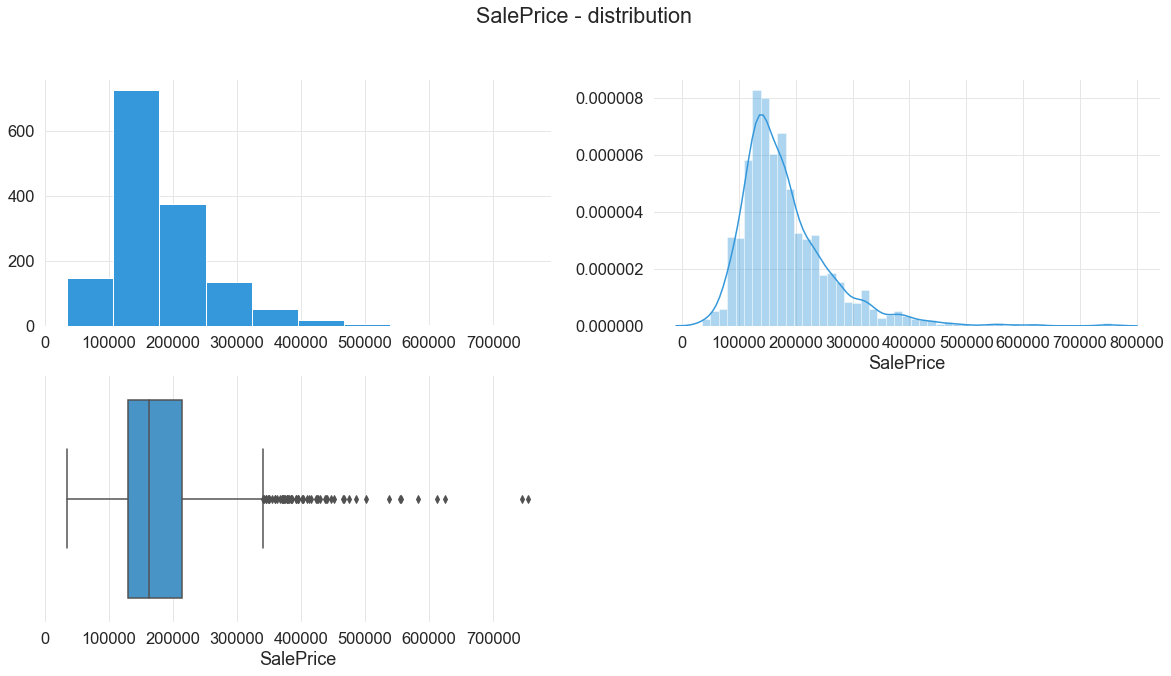

In [368]:
plt.figure(figsize=(20,10));
plt.subplot(2,2,1)
plt.hist(x=df_train.SalePrice);
plt.subplot(2,2,2)
sns.distplot(df_train.SalePrice);
plt.subplot(2,2,3)
sns.boxplot(df_train.SalePrice);
plt.suptitle("SalePrice - distribution");

In [369]:
print (f"Skewness in data : {df_train.SalePrice.skew()}")

Skewness in data : 1.8828757597682129


<h3 style='background-color:yellow'>
Continuous variable <br>
Positively skewed distribution.<br>
Presence of outliers.
</h3>

### 1. MSSubClass
Identifies the type of dwelling involved in the sale.<br>
 20	1-STORY 1946 & NEWER ALL STYLES<br>
        30	1-STORY 1945 & OLDER<br>
        40	1-STORY W/FINISHED ATTIC ALL AGES<br>
        45	1-1/2 STORY - UNFINISHED ALL AGES<br>
        50	1-1/2 STORY FINISHED ALL AGES<br>
        60	2-STORY 1946 & NEWER<br>
        70	2-STORY 1945 & OLDER<br>
        75	2-1/2 STORY ALL AGES<br>
        80	SPLIT OR MULTI-LEVEL<br>
        85	SPLIT FOYER<br>
        90	DUPLEX - ALL STYLES AND AGES<br>
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER<br>
       150	1-1/2 STORY PUD - ALL AGES<br>
       160	2-STORY PUD - 1946 & NEWER<br>
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER<br>
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES<br>

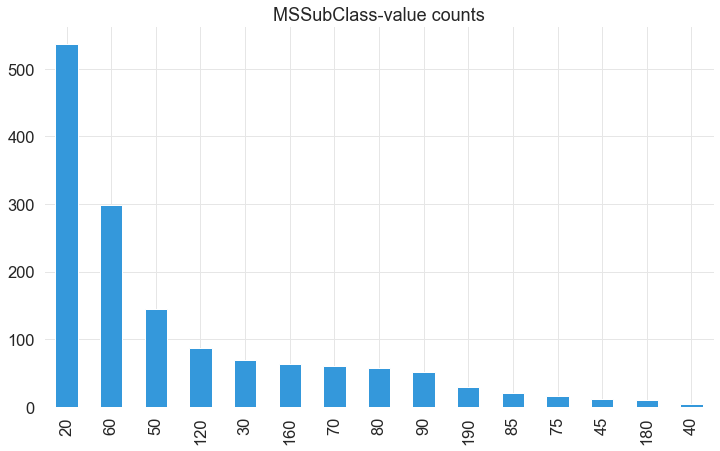

In [370]:
df_train.MSSubClass.value_counts().plot.bar();
plt.title("MSSubClass-value counts");

<h3 style='background-color:yellow'>
Discrete variable.
</h3>

### 2. MSZoning       
Identifies the general zoning classification of the sale.
    A	Agriculture <br>
       C	Commercial<br>
       FV	Floating Village Residential<br>
       I	Industrial<br>
       RH	Residential High Density<br>
       RL	Residential Low Density<br>
       RP	Residential Low Density Park <br>
       RM	Residential Medium Density<br>

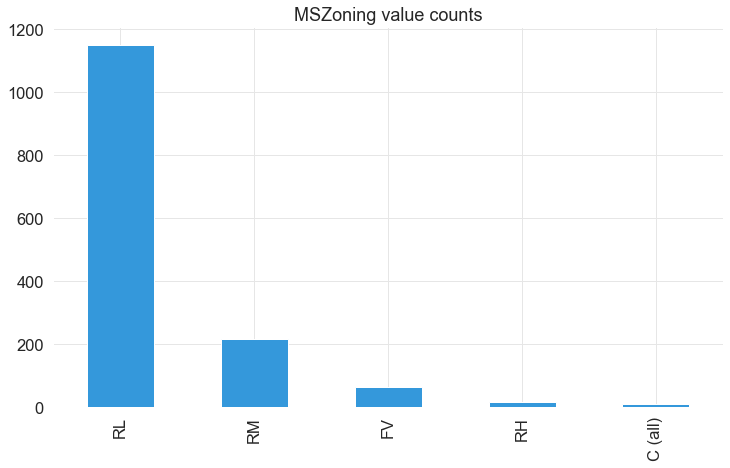

In [371]:
df_train.MSZoning.value_counts().plot.bar();
plt.title("MSZoning value counts");

<h3 style='background-color:yellow'>
Categorical variable.
</h3>

### 3. LotFrontage    
Linear feet of street connected to property

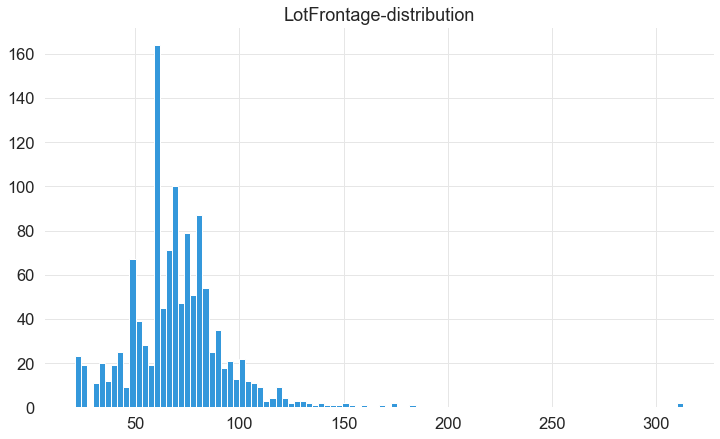

In [372]:
plt.hist(x=df_train.LotFrontage,bins=100);
plt.title("LotFrontage-distribution");

In [373]:
print ("Descriptive statistics:")
df_train.LotFrontage.describe()

Descriptive statistics:


count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

<h3 style='background-color:yellow'>
Continuous variable. <br>
Missing values present.
</h3>

## 4. LotArea
Lot size in square feet

In [374]:
df_train.LotArea.describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

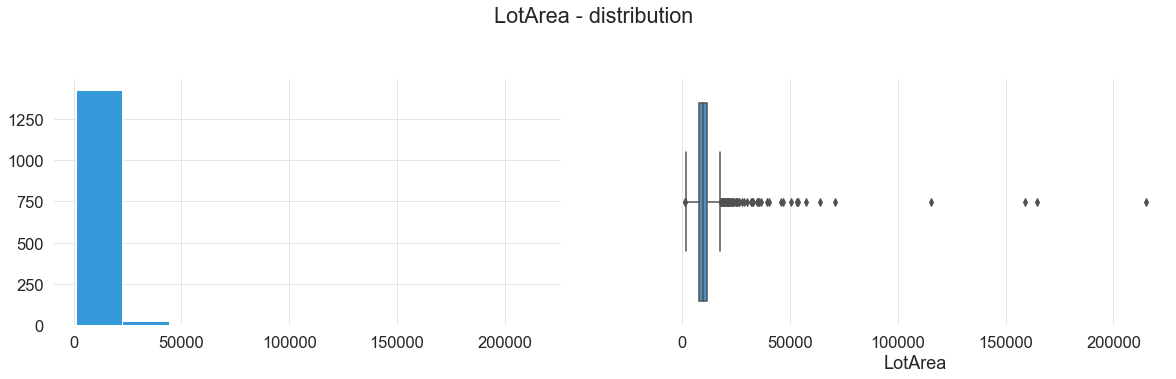

In [375]:
plt.figure(figsize=(20,10));
plt.subplot(2,2,1);
plt.hist(df_train.LotArea);
plt.subplot(2,2,2);
sns.boxplot(df_train.LotArea);
plt.suptitle("LotArea - distribution");

<h3 style='background-color:yellow'>
Continuous variable
</h3>

## 5. Street
Type of road access to property<br>
       Grvl	Gravel	<br>
       Pave	Paved

In [376]:
print (f"Unique values: \n")
np.unique(df_train.Street,return_counts=True)

Unique values: 



(array(['Grvl', 'Pave'], dtype=object), array([   6, 1454], dtype=int64))

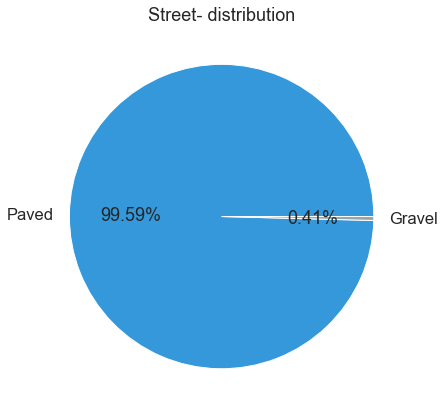

In [377]:
plt.pie(df_train.Street.value_counts(), autopct=lambda s: f'{s:.2f}%',labels=["Paved","Gravel"]);
plt.title("Street- distribution");

<h3 style='background-color:yellow'>
String Categorical variable. <br>
Almost  99% values are 'Paved'
</h3>

### 6. Alley
Type of alley access to property <br>
   Grvl	Gravel <br>
       Pave	Paved<br>
       NA 	No alley access<br>


In [378]:
print ("Value counts:\n")
df_train.Alley.value_counts()

Value counts:



Grvl    50
Pave    41
Name: Alley, dtype: int64

<h3 style='background-color:yellow'>
Categorical string values.<br>
Presence of Null values. <br>
Null/Missing value indicates 'No Alley Access'. <br>
Hence most of the observations having 'No Alley Access'.
</h3>

## 7. LotShape
General shape of property <br>

       Reg	Regular	 <br>
       IR1	Slightly irregular <br>
       IR2	Moderately Irregular<br>
       IR3	Irregular<br>

In [379]:
print ("Value counts:\n")
df_train.LotShape.value_counts()

Value counts:



Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

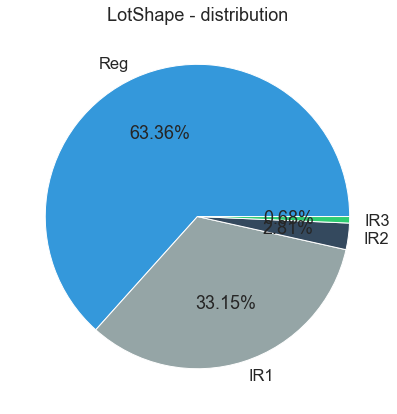

In [380]:
plt.pie(df_train.LotShape.value_counts(), autopct=lambda s: f'{s:.2f}%',labels=df_train.LotShape.value_counts().index);
plt.title("LotShape - distribution");

<h3 style='background-color:yellow'>
String categorical variable.
</h3>

### 8. LandContour    
 Flatness of the property

       Lvl	Near Flat/Level	 <br>
       Bnk	Banked - Quick and significant rise from street grade to building<br>
       HLS	Hillside - Significant slope from side to side<br>
       Low	Depression<br>

In [381]:
print ("Value counts:")
df_train.LandContour.value_counts()

Value counts:


Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

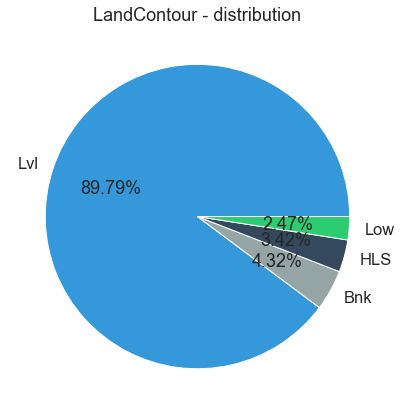

In [382]:
plt.pie(df_train.LandContour.value_counts(), autopct=lambda s: f'{s:.2f}%',labels=df_train.LandContour.value_counts().index);
plt.title("LandContour - distribution");

<h3 style='background-color:yellow'>
Categorical String variable
</h3>

### 9. Utilities
Type of utilities available <br>
  AllPub	All public Utilities (E,G,W,& S)	<br>
       NoSewr	Electricity, Gas, and Water (Septic Tank)<br>
       NoSeWa	Electricity and Gas Only<br>
       ELO	Electricity only<br>

In [383]:
print ("Value Counts:\n")
df_train.Utilities.value_counts()

Value Counts:



AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

<h3 style='background-color:yellow'>
Categorical String variable.
</h3>

### 10. LotConfig      
Lot configuration<br>

       Inside	Inside lot<br>
       Corner	Corner lot<br>
       CulDSac	Cul-de-sac<br>
       FR2	Frontage on 2 sides of property<br>
       FR3	Frontage on 3 sides of property<br>


Value counts: 

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Null value count :  0


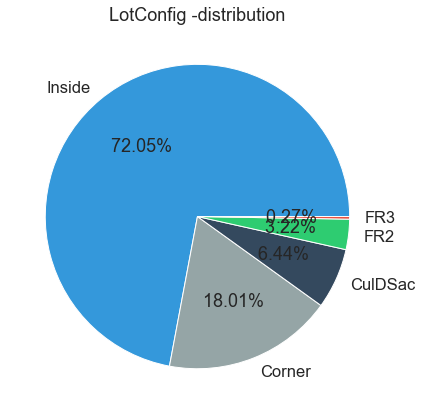

In [384]:
str_discrete_analysis(df_train.LotConfig)

<h3 style='background-color:yellow'>
String Categorical variable. <br>
</h3>

### 11. LandSlope 
Slope of property<br>
		
       Gtl	Gentle slope<br>
       Mod	Moderate Slope	<br>
       Sev	Severe Slope<br>

Value counts: 

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
Null value count :  0


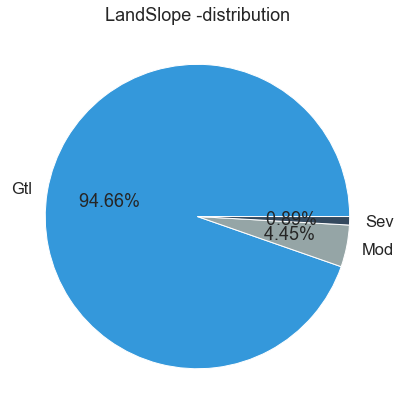

In [385]:
str_discrete_analysis(df_train.LandSlope)

<h3 style='background-color:yellow'>
String Categorical variable.
</h3>

### 12. Neighborhood   
Physical locations within Ames city limits<br>

       Blmngtn	Bloomington Heights<br>
       Blueste	Bluestem<br>
       BrDale	Briardale<br>
       BrkSide	Brookside<br>
       ClearCr	Clear Creek<br>
       CollgCr	College Creek<br>
       Crawfor	Crawford<br>
       Edwards	Edwards<br>
       Gilbert	Gilbert<br>
       IDOTRR	Iowa DOT and Rail Road<br>
       MeadowV	Meadow Village<br>
       Mitchel	Mitchell<br>
       Names	North Ames<br>
       NoRidge	Northridge<br>
       NPkVill	Northpark Villa<br>
       NridgHt	Northridge Heights<br>
       NWAmes	Northwest Ames<br>
       OldTown	Old Town<br>
       SWISU	South & West of Iowa State University<br>
       Sawyer	Sawyer<br>
       SawyerW	Sawyer West<br>
       Somerst	Somerset<br>
       StoneBr	Stone Brook<br>
       Timber	Timberland<br>
       Veenker	Veenker<br>

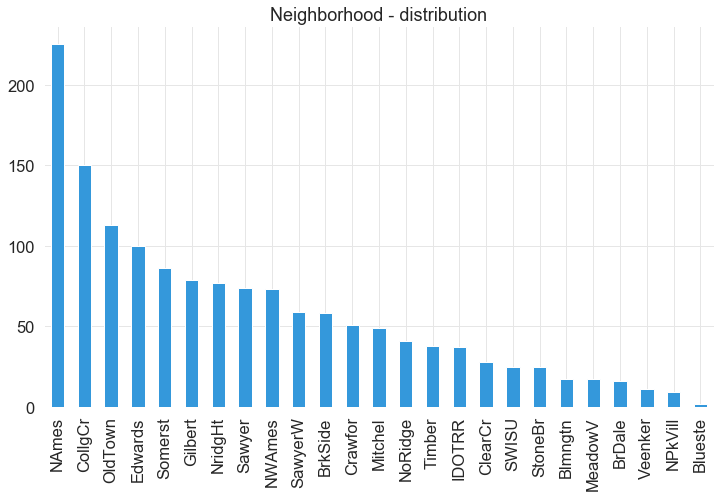

In [386]:
df_train.Neighborhood.value_counts().plot.bar();
plt.title("Neighborhood - distribution");

<h3 style='background-color:yellow'>
Categorical String variable.
</h3>

### 13. Condition1
Proximity to various conditions <br>
	
       Artery	Adjacent to arterial street<br>
       Feedr	Adjacent to feeder street	<br>
       Norm	Normal	<br>
       RRNn	Within 200' of North-South Railroad<br>
       RRAn	Adjacent to North-South Railroad<br>
       PosN	Near positive off-site feature--park, greenbelt, etc.<br>
       PosA	Adjacent to postive off-site feature<br>
       RRNe	Within 200' of East-West Railroad<br>
       RRAe	Adjacent to East-West Railroad<br>

Value counts: 

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
Null value count :  0


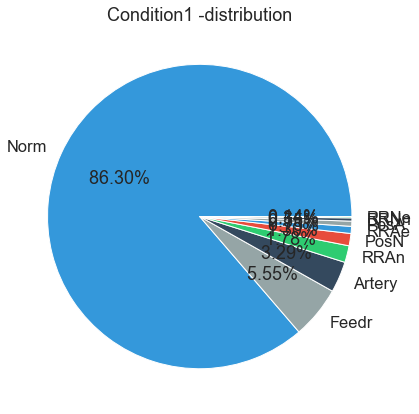

In [387]:
str_discrete_analysis(df_train.Condition1)

In [388]:
display (HTML("<h3 style='background-color:yellow'>String Discrete variable </h3>"))

### 14. Condition2
Proximity to various conditions (if more than one is present)<br>
		
       Artery	Adjacent to arterial street<br>
       Feedr	Adjacent to feeder street	<br>
       Norm	Normal	<br>
       RRNn	Within 200' of North-South Railroad<br>
       RRAn	Adjacent to North-South Railroad<br>
       PosN	Near positive off-site feature--park, greenbelt, etc.<br>
       PosA	Adjacent to postive off-site feature<br>
       RRNe	Within 200' of East-West Railroad<br>
       RRAe	Adjacent to East-West Railroad<br>

Value counts: 

Norm      1445
Feedr        6
RRNn         2
Artery       2
PosN         2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64
Null value count :  0


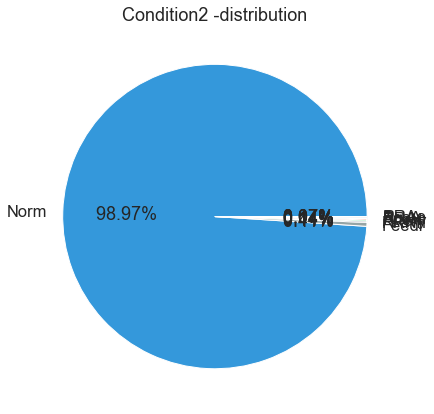

In [389]:
str_discrete_analysis(df_train.Condition2)

<h3 style='background-color:yellow'> String Discrete variable</h3>

### 15. BldgType: Type of dwelling
		
       1Fam	Single-family Detached	<br>
       2FmCon	Two-family Conversion; originally built as one-family dwelling<br>
       Duplx	Duplex<br>
       TwnhsE	Townhouse End Unit<br>
       TwnhsI	Townhouse Inside Unit<br>

Value counts: 

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64
Null value count :  0


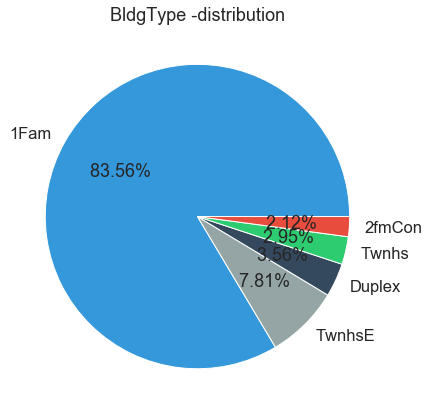

In [390]:
str_discrete_analysis(df_train.BldgType)

<h3 style='background-color:yellow'>String Discrete variable </h3>

### 16. OverallQual: Rates the overall material and finish of the house

       10	Very Excellent<br>
       9	Excellent<br>
       8	Very Good<br>
       7	Good<br>
       6	Above Average<br>
       5	Average<br>
       4	Below Average<br>
       3	Fair<br>
       2	Poor<br>
       1	Very Poor<br>

Value counts: 

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64
Null value count :  0


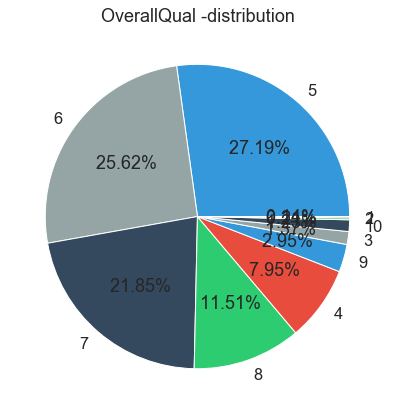

In [391]:
str_discrete_analysis(df_train.OverallQual)

<h3 style='background-color:yellow'> Integer ordinal variable</h3>

### 17. OverallCond: Rates the overall condition of the house

       10	Very Excellent<br>
       9	Excellent<br>
       8	Very Good<br>
       7	Good<br>
       6	Above Average	<br>
       5	Average<br>
       4	Below Average	<br>
       3	Fair<br>
       2	Poor<br>
       1	Very Poor<br>

Value counts: 

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64
Null value count :  0


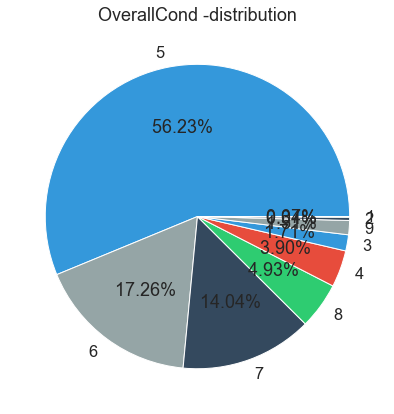

In [392]:
str_discrete_analysis(df_train.OverallCond)

<h3 style='background-color:yellow'>Integer ordinal variable. </h3>

### 18. YearBuilt: Original construction date

In [393]:
df_train.YearBuilt.describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

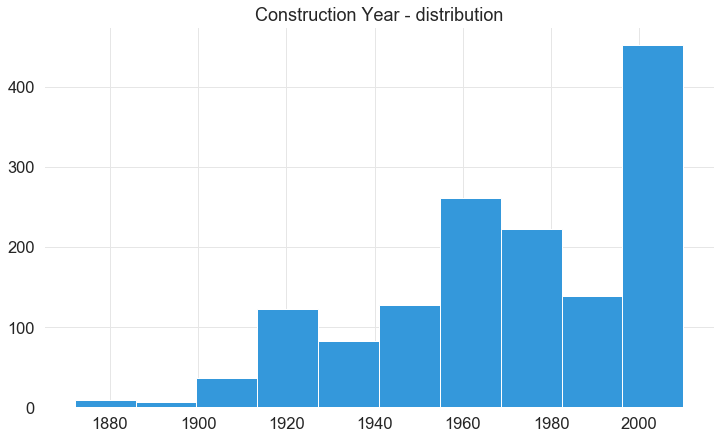

In [394]:
plt.hist(df_train.YearBuilt);
plt.title("Construction Year - distribution");

<h3 style='background-color:yellow'>
Categorical variable.
</h3>

### 19. YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

In [395]:
df_train.YearRemodAdd.describe()

count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

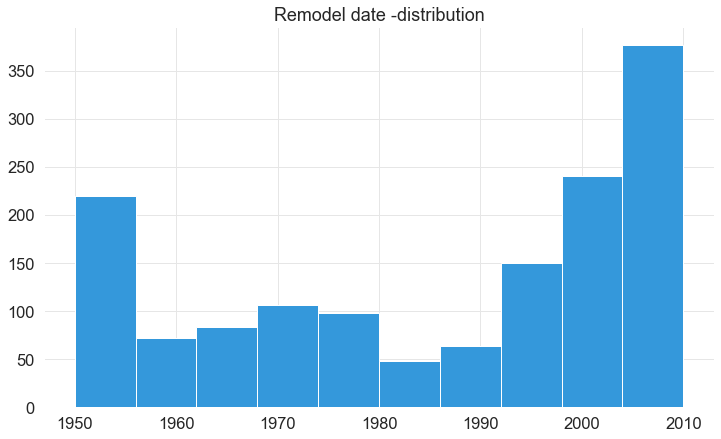

In [396]:
plt.hist(df_train.YearRemodAdd);
plt.title("Remodel date -distribution");

<h3 style='background-color:yellow'>
Discrete variable.
</h3>

### 20. RoofStyle: Type of roof

       Flat	Flat<br>
       Gable	Gable<br>
       Gambrel	Gabrel (Barn)<br>
       Hip	Hip<br>
       Mansard	Mansard<br>
       Shed	Shed<br>

Value counts: 

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64
Null value count :  0


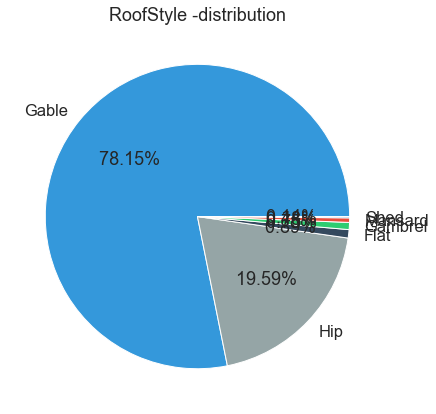

In [397]:
str_discrete_analysis(df_train.RoofStyle)

<h3 style='background-color:yellow'>
Categorial variable.
</h3>

## 21. RoofMatl: Roof material

       ClyTile	Clay or Tile<br>
       CompShg	Standard (Composite) Shingle<br>
       Membran	Membrane<br>
       Metal	Metal<br>
       Roll	Roll<br>
       Tar&Grv	Gravel & Tar<br>
       WdShake	Wood Shakes<br>
       WdShngl	Wood Shingles<br>

Value counts: 

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64
Null value count :  0


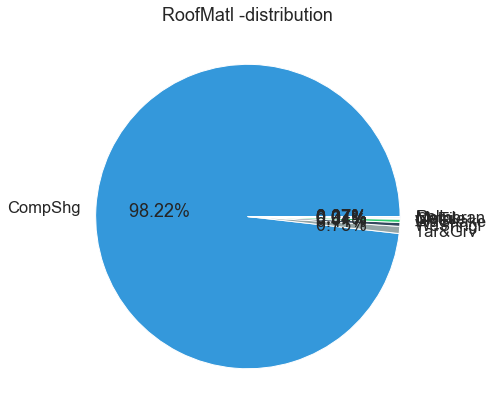

In [398]:
str_discrete_analysis(df_train.RoofMatl)

<h3 style='background-color:yellow'>
Discrete variable.
</h3>

### 23. Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles<br>
       AsphShn	Asphalt Shingles<br>
       BrkComm	Brick Common<br>
       BrkFace	Brick Face<br>
       CBlock	Cinder Block<br>
       CemntBd	Cement Board<br>
       HdBoard	Hard Board<br>
       ImStucc	Imitation Stucco<br>
       MetalSd	Metal Siding<br>
       Other	Other<br>
       Plywood	Plywood<br>
       PreCast	PreCast	<br>
       Stone	Stone<br>
       Stucco	Stucco<br>
       VinylSd	Vinyl Siding<br>
       Wd Sdng	Wood Siding<br>
       WdShing	Wood Shingles<br>

Value counts: 

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
ImStucc      1
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64
Null value count :  0


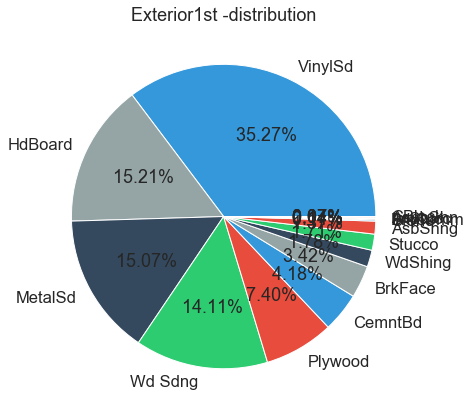

In [399]:
str_discrete_analysis(df_train.Exterior1st)

<h3 style='background-color:yellow'>
Discrete variable.
</h3>

### 23. Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles<br>
       AsphShn	Asphalt Shingles<br>
       BrkComm	Brick Common<br>
       BrkFace	Brick Face<br>
       CBlock	Cinder Block<br>
       CemntBd	Cement Board<br>
       HdBoard	Hard Board<br>
       ImStucc	Imitation Stucco<br>
       MetalSd	Metal Siding<br>
       Other	Other<br>
       Plywood	Plywood<br>
       PreCast	PreCast<br>
       Stone	Stone<br>
       Stucco	Stucco<br>
       VinylSd	Vinyl Siding<br>
       Wd Sdng	Wood Siding<br>
       WdShing	Wood Shingles<br>

Value counts: 

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64
Null value count :  0


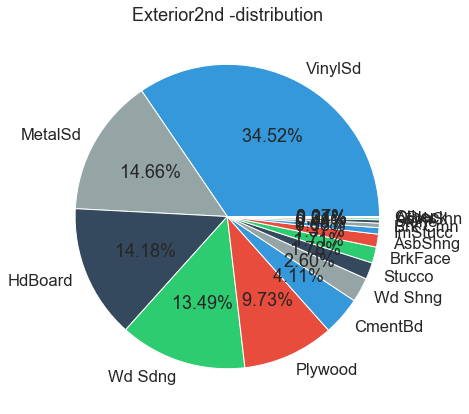

In [400]:
str_discrete_analysis(df_train.Exterior2nd)

<h3 style='background-color:yellow'>
Discrete variable.
</h3>

### 23. MasVnrType: Masonry veneer type

       BrkCmn	Brick Common<br>
       BrkFace	Brick Face<br>
       CBlock	Cinder Block<br>
       None	None<br>
       Stone	Stone<br>

Value counts: 

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
Null value count :  8


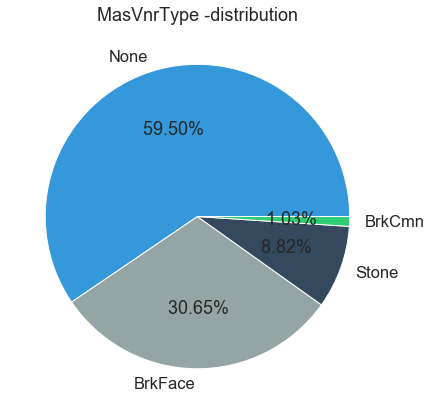

In [401]:
str_discrete_analysis(df_train.MasVnrType)

<h3 style='background-color:yellow'>
Discrete variable.
</h3>

### 24. MasVnrArea: Masonry veneer area in square feet 

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64
Null value count :  8


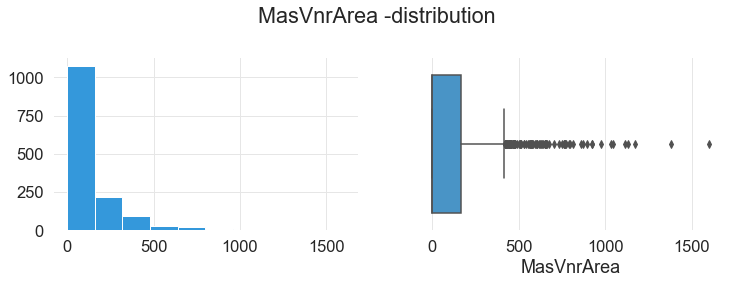

In [402]:
conti_fld_analysis(df_train.MasVnrArea)

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 25. ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent<br>
       Gd	Good<br>
       TA	Average/Typical<br>
       Fa	Fair<br>
       Po	Poor<br>

Value counts: 

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64
Null value count :  0


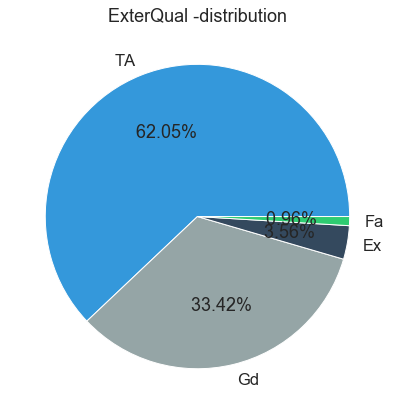

In [403]:
str_discrete_analysis(df_train.ExterQual)

<h3 style='background-color:yellow'>
Ordinal variable.
</h3>

### 26. ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent<br>
       Gd	Good<br>
       TA	Average/Typical<br>
       Fa	Fair<br>
       Po	Poor<br>

Value counts: 

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
Null value count :  0


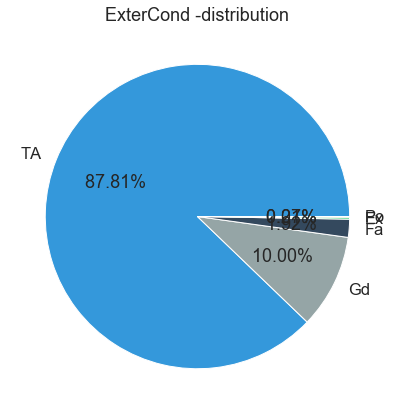

In [404]:
str_discrete_analysis(df_train.ExterCond)

<h3 style='background-color:yellow'>
Ordinal variable.
</h3>

### 27. Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

Value counts: 

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64
Null value count :  0


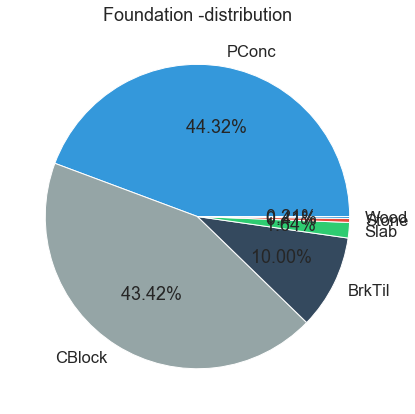

In [405]:
str_discrete_analysis(df_train.Foundation)

<h3 style='background-color:yellow'>
String categorical variable. <br>
</h3>

### 28. BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

Value counts: 

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
Null value count :  37


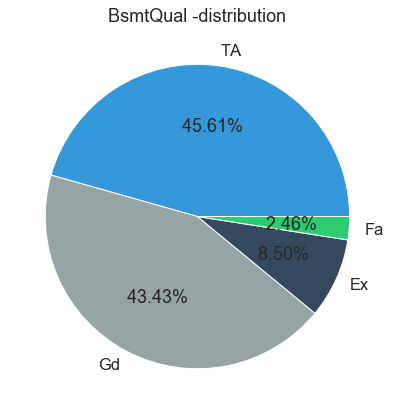

In [406]:
str_discrete_analysis(df_train.BsmtQual)

<h3 style='background-color:yellow'>
Ordinal variable.
</h3>

### 29. BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

Value counts: 

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
Null value count :  37


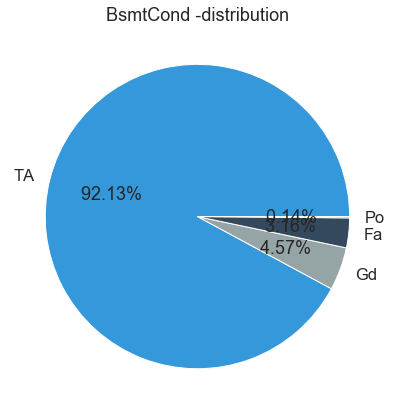

In [407]:
str_discrete_analysis(df_train.BsmtCond)

<h3 style='background-color:yellow'>
Ordinal variable.
</h3>

### 30. BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
 

Value counts: 

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
Null value count :  38


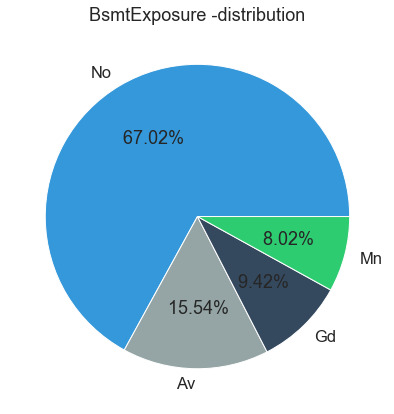

In [408]:
str_discrete_analysis(df_train.BsmtExposure)

<h3 style='background-color:yellow'>
Ordinal variable.
</h3>

### 31. BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Value counts: 

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64
Null value count :  37


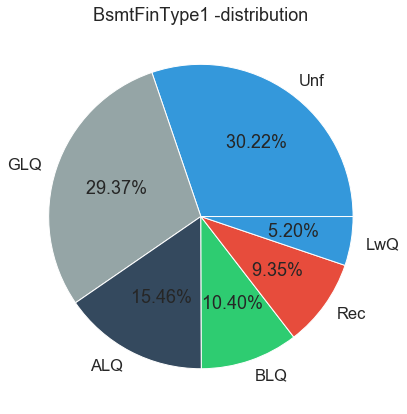

In [409]:
str_discrete_analysis(df_train.BsmtFinType1)

<h3 style='background-color:yellow'>
Ordinal variable.
</h3>

### 32. BsmtFinSF1: Type 1 finished square feet

count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64
Null value count :  0


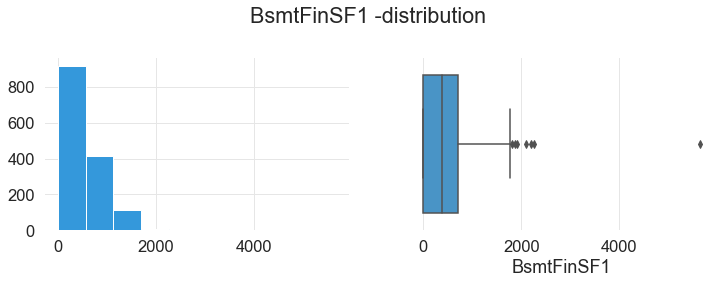

In [410]:
conti_fld_analysis(df_train.BsmtFinSF1)

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 33. BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Value counts: 

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
Null value count :  38


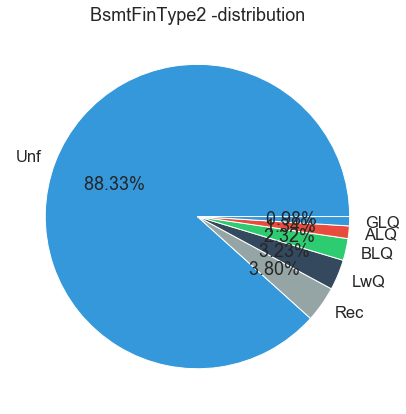

In [411]:
str_discrete_analysis(df_train.BsmtFinType2)

<h3 style='background-color:yellow'>
Ordinal variable.
</h3>

### 34. BsmtFinSF2: Type 2 finished square feet

count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64
Null value count :  0


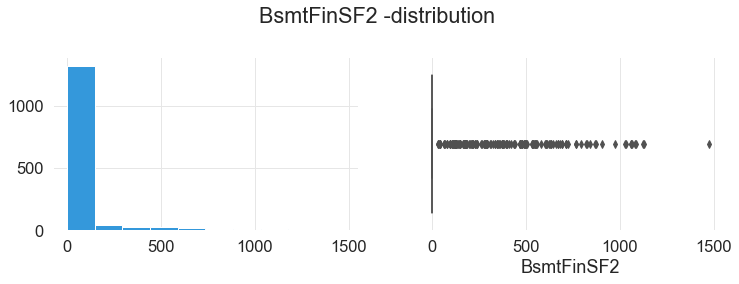

In [412]:
conti_fld_analysis(df_train.BsmtFinSF2)

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 35. BsmtUnfSF: Unfinished square feet of basement area

count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64
Null value count :  0


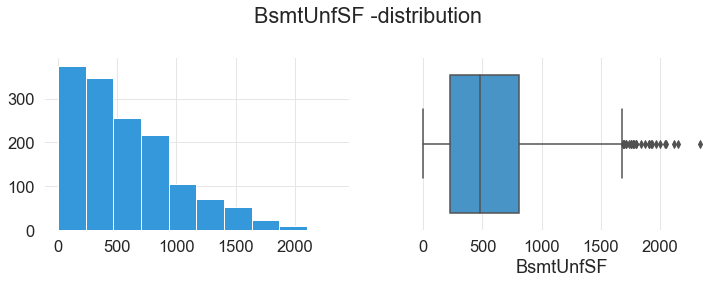

In [413]:
conti_fld_analysis(df_train.BsmtUnfSF)

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 36. TotalBsmtSF: Total square feet of basement area

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64
Null value count :  0


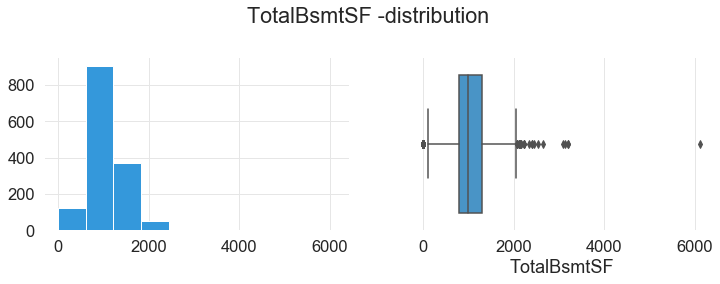

In [414]:
conti_fld_analysis(df_train.TotalBsmtSF)

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 37. Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

In [415]:
df_train.Heating.value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

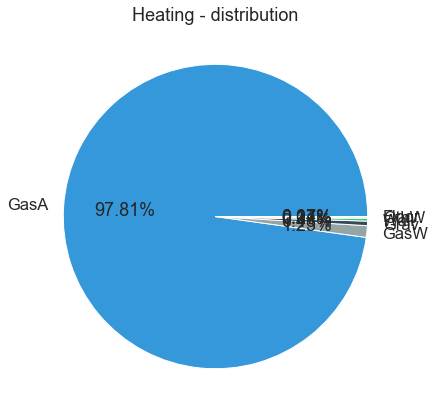

In [416]:
plt.pie(df_train.Heating.value_counts(),autopct=lambda s: f'{s:.2f}%',labels=df_train.Heating.value_counts().index);
plt.title("Heating - distribution");

<h3 style='background-color:yellow'>
String Categorical variable
</h3>

### 38. HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [417]:
df_train.HeatingQC.value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

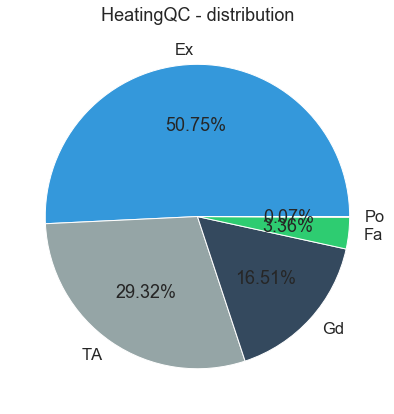

In [418]:
plt.pie(df_train.HeatingQC.value_counts(),autopct=lambda s: f'{s:.2f}%', labels=df_train.HeatingQC.value_counts().index);
plt.title("HeatingQC - distribution");

<h3 style='background-color:yellow'>
Ordinal
  variable.
</h3>

### 39. CentralAir: Central air conditioning

       N	No
       Y	Yes

Value counts: 

Y    1365
N      95
Name: CentralAir, dtype: int64
Null value count :  0


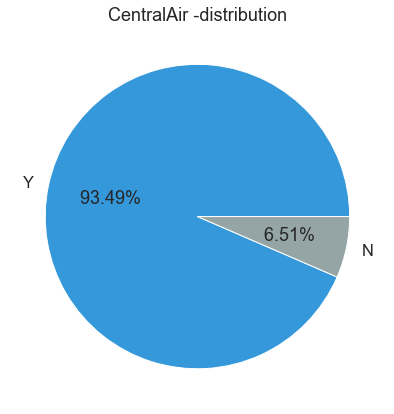

In [419]:
str_discrete_analysis(df_train.CentralAir)

<h3 style='background-color:yellow'>
Categorical String variable.<br>
93% houses are Airconditioned.<br>
</h3>

### 40. Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

Value counts: 

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
Null value count :  1


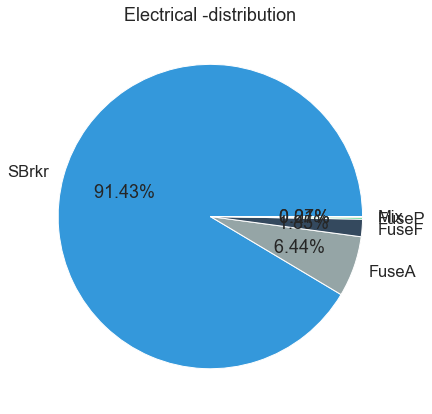

In [420]:
str_discrete_analysis(df_train.Electrical)

<h3 style='background-color:yellow'> String Discrete variable</h3>

### 41. 1stFlrSF: First Floor square feet

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64
Null value count :  0


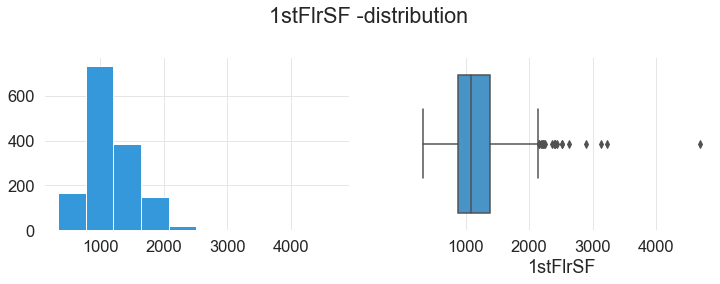

In [421]:
conti_fld_analysis(df_train["1stFlrSF"])

### 42. 2ndFlrSF: Second floor square feet

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64
Null value count :  0


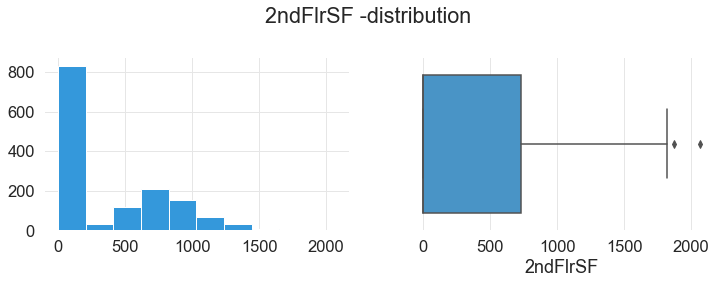

In [422]:
conti_fld_analysis(df_train["2ndFlrSF"])

<h3 style='background-color:yellow'>Continuous variable. </h3>

### 43. LowQualFinSF: Low quality finished square feet (all floors)

In [423]:
df_train.LowQualFinSF.describe()

count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

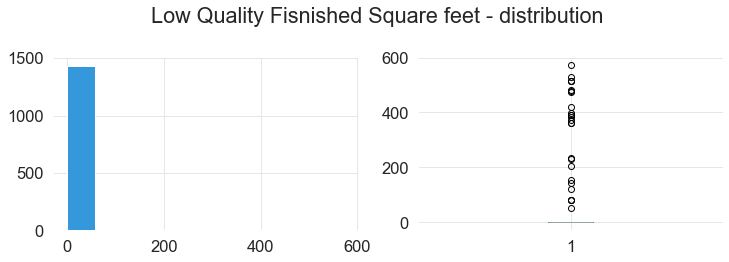

In [424]:
plt.subplot(2,2,1)
plt.hist(df_train.LowQualFinSF);
plt.subplot(2,2,2)
plt.boxplot(df_train.LowQualFinSF);
plt.suptitle("Low Quality Fisnished Square feet - distribution");

<h3 style='background-color:yellow'>
Continuous variable
</h3>

### 44. GrLivArea: Above grade (ground) living area square feet

In [425]:
df_train.GrLivArea.describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

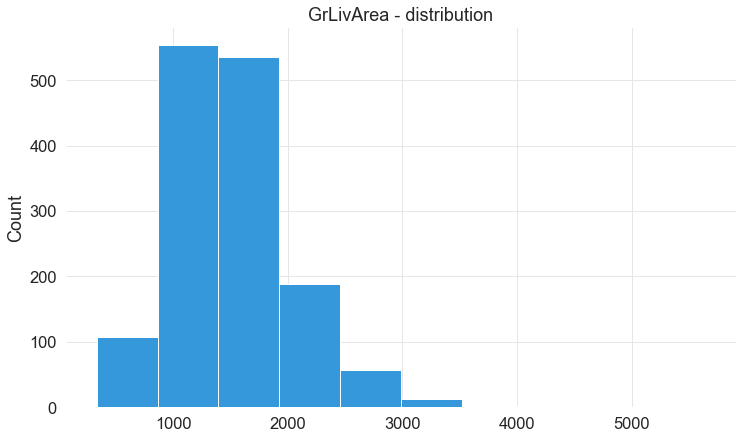

In [426]:
plt.hist(df_train.GrLivArea);
plt.title("GrLivArea - distribution");
plt.ylabel("Count");

### 45. BsmtFullBath: Basement full bathrooms

Value counts: 

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64
Null value count :  0


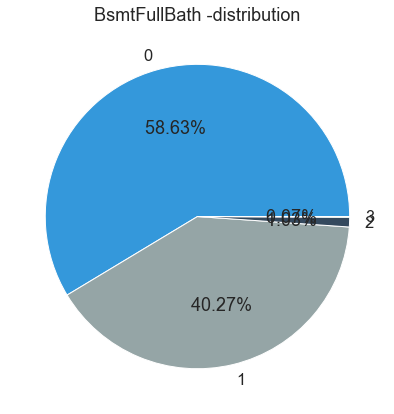

In [427]:
str_discrete_analysis(df_train.BsmtFullBath)

<h3 style='background-color:yellow'>
Ordinal variable
</h3>

### 46. BsmtHalfBath: Basement half bathrooms

Value counts: 

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64
Null value count :  0


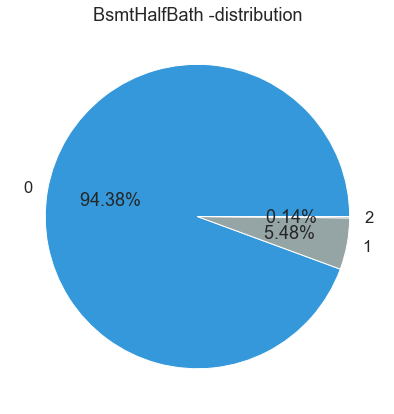

In [428]:
str_discrete_analysis(df_train.BsmtHalfBath)

<h3 style='background-color:yellow'>Ordinal variable. </h3>

### 47. FullBath: Full bathrooms above grade

Value counts: 

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64
Null value count :  0


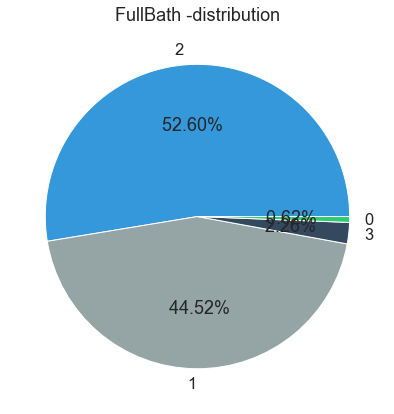

In [429]:
str_discrete_analysis(df_train.FullBath)

<h3 style='background-color:yellow'>Ordinal variable </h3>

### 48. HalfBath: Half baths above grade

Value counts: 

0    913
1    535
2     12
Name: HalfBath, dtype: int64
Null value count :  0


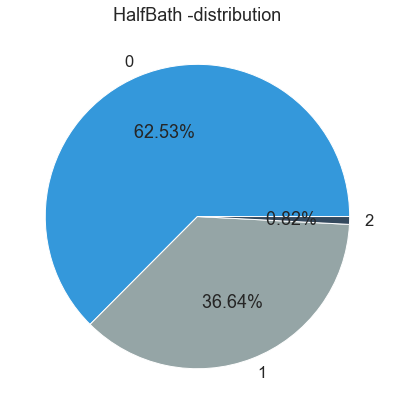

In [430]:
str_discrete_analysis(df_train.HalfBath)

<h3 style='background-color:yellow'> Ordinal variable</h3>

### 49. BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)

Value counts: 

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64
Null value count :  0


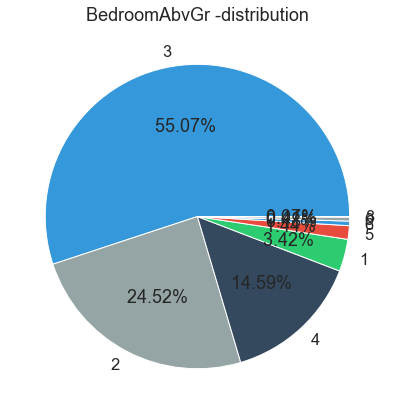

In [431]:
str_discrete_analysis(df_train.BedroomAbvGr)

<h3 style='background-color:yellow'> Ordinal variable</h3>

### 50. KitchenAbvGr: Kitchens above grade

Value counts: 

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64
Null value count :  0


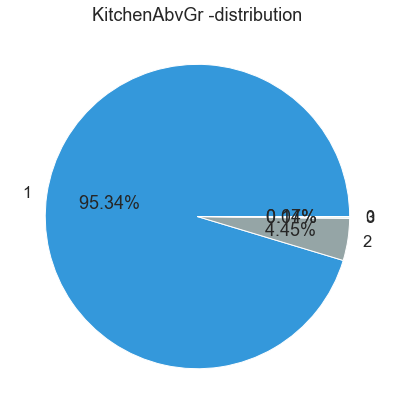

In [432]:
str_discrete_analysis(df_train.KitchenAbvGr)

<h3 style='background-color:yellow'> 
Ordinal feature.<br>
Most of the houses having 1 kitchen with above grade.
</h3>

### 51. KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [433]:
df_train.KitchenQual.value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

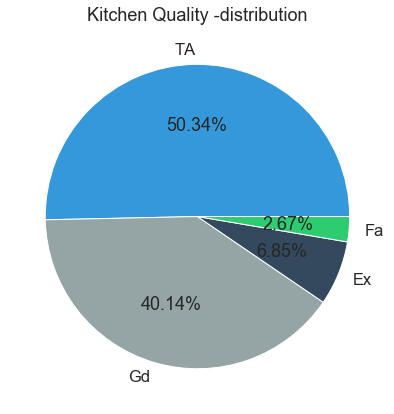

In [434]:
plt.pie(df_train.KitchenQual.value_counts(),labels=df_train.KitchenQual.value_counts().index,autopct=lambda x: f'{x:.2f}%');
plt.title("Kitchen Quality -distribution");

<h3 style='background-color:yellow'>
Ordinal variable.
    50% of the houses having average Kitchen.
    <br> Only 7% having excellent kitchens.
</h3>

### 52. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Value counts: 

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64
Null value count :  0


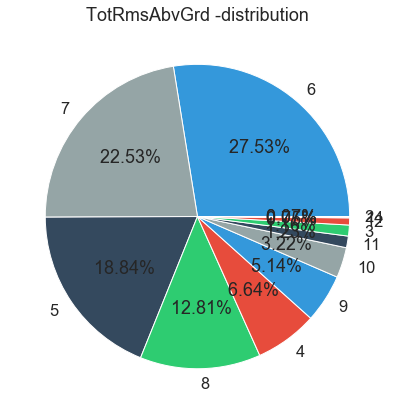

In [435]:
str_discrete_analysis(df_train.TotRmsAbvGrd)

<h3 style='background-color:yellow'>Ordinal variable. </h3>

### 53. Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

Value counts: 

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64
Null value count :  0


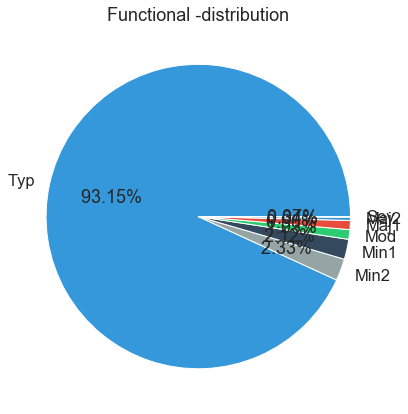

In [436]:
str_discrete_analysis(df_train.Functional)

<h3 style='background-color:yellow'> Discrete variable.</h3>

### 54. Fireplaces: Number of fireplaces

In [437]:
df_train.Fireplaces.describe()

count    1460.000000
mean        0.613014
std         0.644666
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64

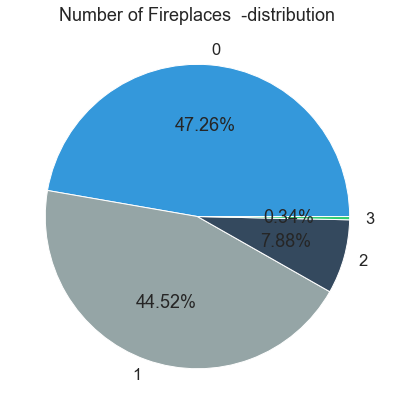

In [438]:
plt.pie(df_train.Fireplaces.value_counts(),autopct=lambda s : f'{s:.2f}%',labels=df_train.Fireplaces.value_counts().index);
plt.title("Number of Fireplaces  -distribution");

<h3 style='background-color:yellow'>
Ordinal variable.
</h3>

### 55. FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

Value counts: 

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
Null value count :  690


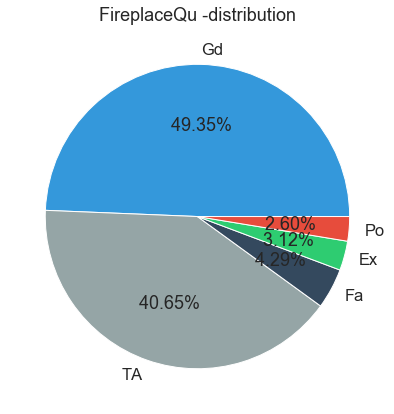

In [439]:
str_discrete_analysis(df_train.FireplaceQu)

<h3 style='background-color:yellow'>
Ordinal variable. <br>
50% of the houses having good Fireplace quality.
</h3>

### 56. GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

Value counts: 

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
Null value count :  81


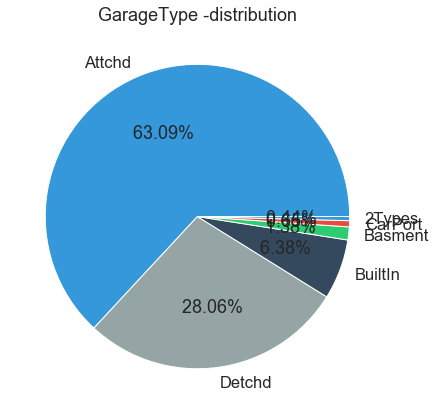

In [440]:
str_discrete_analysis(df_train.GarageType)

<h3 style='background-color:yellow'>
Discrete variable <br>
63% of the houses having Attached Garage</h3>

### 57.  GarageYrBlt: Year garage was built

In [441]:
df_train.GarageYrBlt.describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

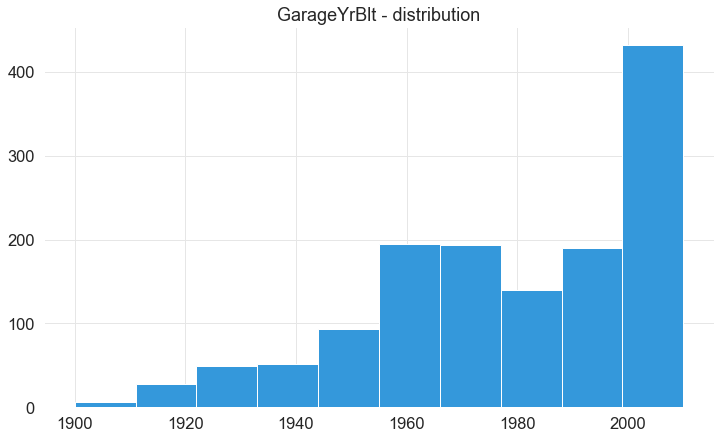

In [442]:
plt.hist(df_train.GarageYrBlt);
plt.title("GarageYrBlt - distribution");

<h3 style='background-color:yellow'>
Discrete variable.
</h3>

### 58. GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

Value counts: 

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64
Null value count :  81


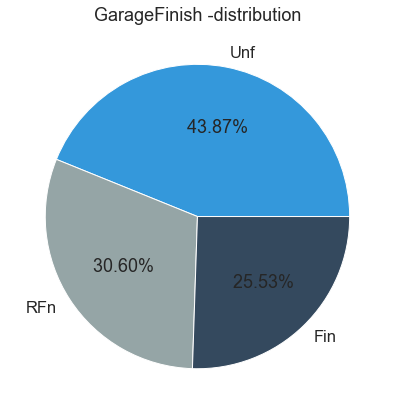

In [443]:
str_discrete_analysis(df_train.GarageFinish)

<h3 style='background-color:yellow'> 
Ordinal variable <br>
Null values present.    
</h3>

### 59. GarageCars: Size of garage in car capacity

Value counts: 

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64
Null value count :  0


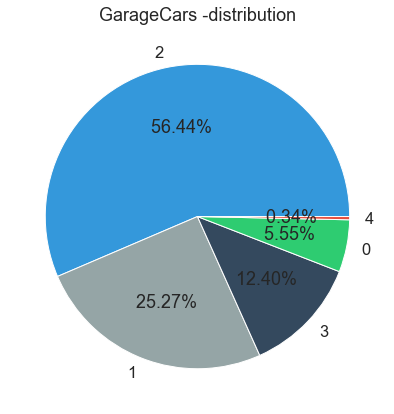

In [444]:
str_discrete_analysis(df_train.GarageCars)

<h3 style='background-color:yellow'> 
Ordinal variable.<br>
    56% of the Garages having 2 car capacity.
</h3>

### 60. GarageArea: Size of garage in square feet

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64
Null value count :  0


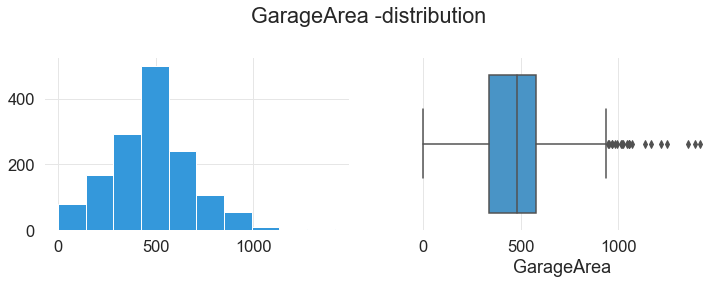

In [445]:
conti_fld_analysis(df_train.GarageArea)

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 61. GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

Value counts: 

TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64
Null value count :  81


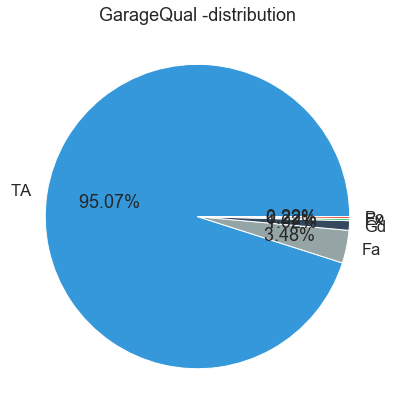

In [446]:
str_discrete_analysis(df_train.GarageQual)

<h3 style='background-color:yellow'> Most of Garage quality is average.
    <br> Ordinal variable.
</h3>

### 62. GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

Value counts: 

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64
Null value count :  81


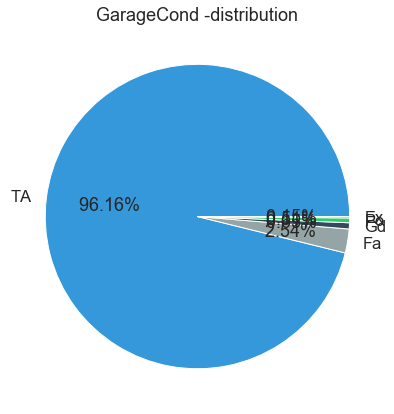

In [447]:
str_discrete_analysis(df_train.GarageCond)

<h3 style='background-color:yellow'>
Ordinal variable. <br>
    Most of the Garage condition is Average.
</h3>

### 63. PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

Value counts: 

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64
Null value count :  0


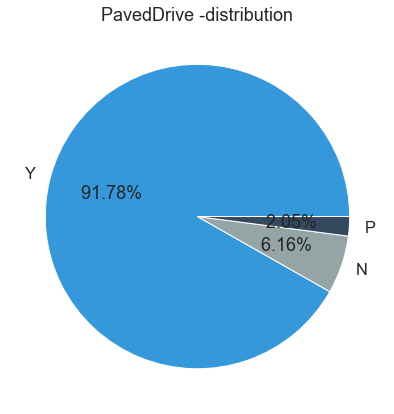

In [448]:
str_discrete_analysis(df_train.PavedDrive)

<h3 style='background-color:yellow'>
Ordinal variable <br>
    Most of the houses having Paved Driveway.
</h3>

### 64. WoodDeckSF: Wood deck area in square feet

count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64
Null value count :  0


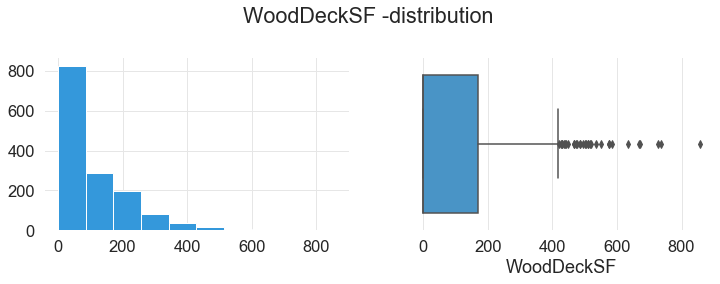

In [449]:
conti_fld_analysis(df_train.WoodDeckSF)

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 65. OpenPorchSF: Open porch area in square feet

count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64
Null value count :  0


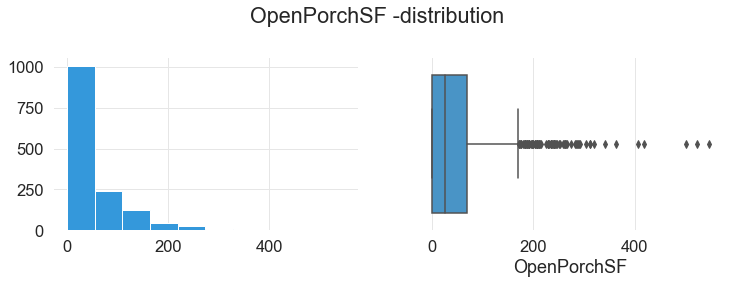

In [450]:
conti_fld_analysis(df_train.OpenPorchSF)

<h3 style='background-color:yellow'> 
Continuous variable.
</h3>

### 66. EnclosedPorch: Enclosed porch area in square feet

In [451]:
df_train.EnclosedPorch.describe()

count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

Text(0.5, 0.98, 'EnclosedPorch - distribution')

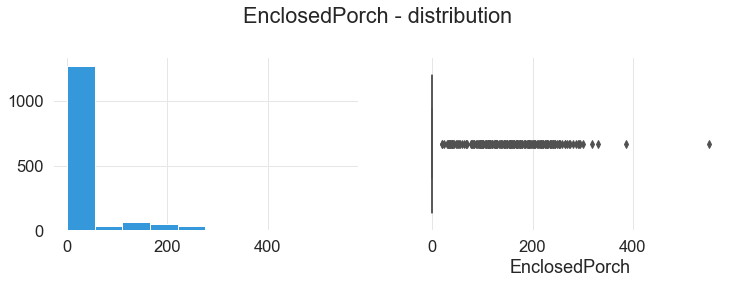

In [452]:
plt.subplot(2,2,1)
plt.hist(df_train.EnclosedPorch);
plt.subplot(2,2,2)
sns.boxplot(df_train.EnclosedPorch);
plt.suptitle("EnclosedPorch - distribution")


<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 67. 3SsnPorch: Three season porch area in square feet

count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64
Null value count :  0


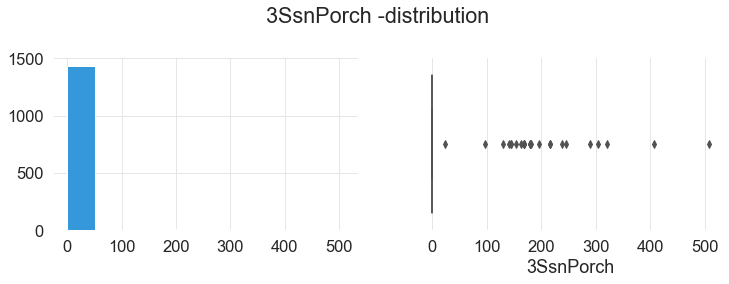

In [453]:
conti_fld_analysis(df_train["3SsnPorch"])

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 68. ScreenPorch: Screen porch area in square feet

count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64
Null value count :  0


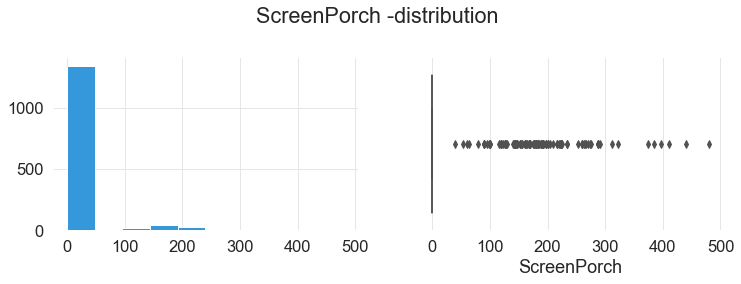

In [454]:
conti_fld_analysis(df_train.ScreenPorch)

<h3 style='background-color:yellow'>Continuous variable. </h3>

### 69. PoolArea: Pool area in square feet

In [455]:
df_train.PoolArea.describe()

count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

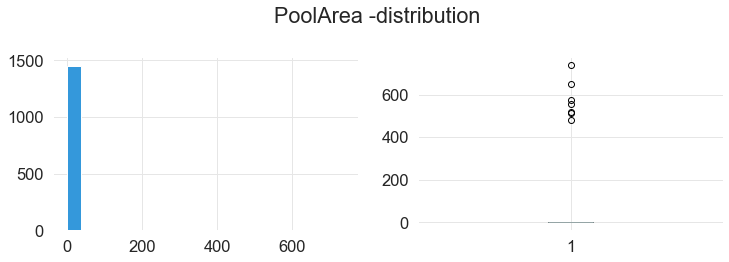

In [456]:
plt.subplot(2,2,1)
plt.hist(df_train.PoolArea, bins=20);
plt.subplot(2,2,2)
plt.boxplot(df_train.PoolArea);
plt.suptitle("PoolArea -distribution");

<h3 style='background-color:yellow'>
Continuous variable.
</h3>

### 70. PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

Value counts: 

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64
Null value count :  1453


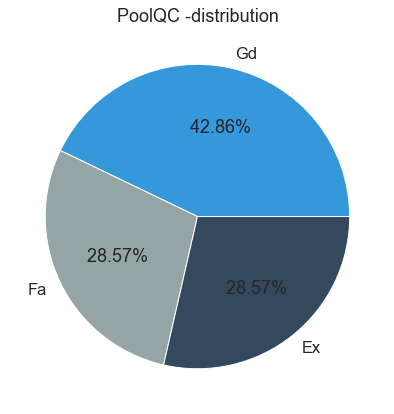

In [457]:
str_discrete_analysis(df_train.PoolQC)

<h3 style='background-color:yellow'>
Ordinal variable
</h3>

### 71. Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

In [458]:
df_train.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

<h3 style='background-color:yellow'>
Ordinal variable. <br>
Presence of missing values.
</h3>

### 72. MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

Value counts: 

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64
Null value count :  1406


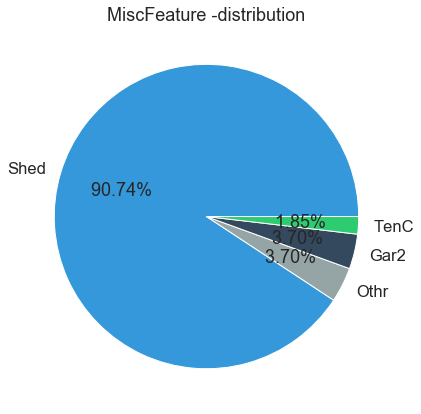

In [459]:
str_discrete_analysis(df_train.MiscFeature)

<h3 style='background-color:yellow'> Discrete variable.</h3>

### 73. MiscVal: $Value of miscellaneous feature

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64
Null value count :  0


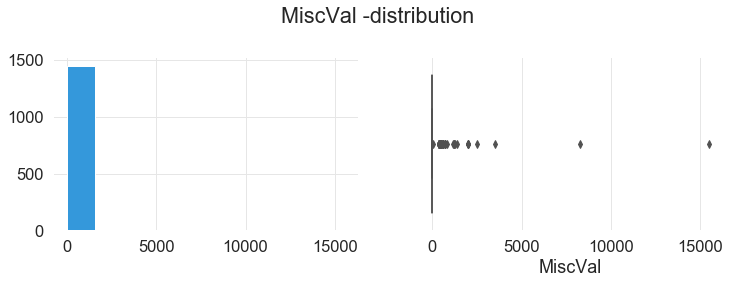

In [460]:
conti_fld_analysis(df_train.MiscVal)

<h3 style='background-color:yellow'> Continuous variable.</h3>

### 74. MoSold: Month Sold (MM)

In [461]:
print (f"Unique values: {df_train.MoSold.unique().tolist()}")

Unique values: [2, 5, 9, 12, 10, 8, 11, 4, 1, 7, 3, 6]


<h3 style='background-color:yellow'>
Discrete variable.
</h3>

### 75. YrSold: Year Sold (YYYY)

In [462]:
df_train.YrSold.describe()

count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64

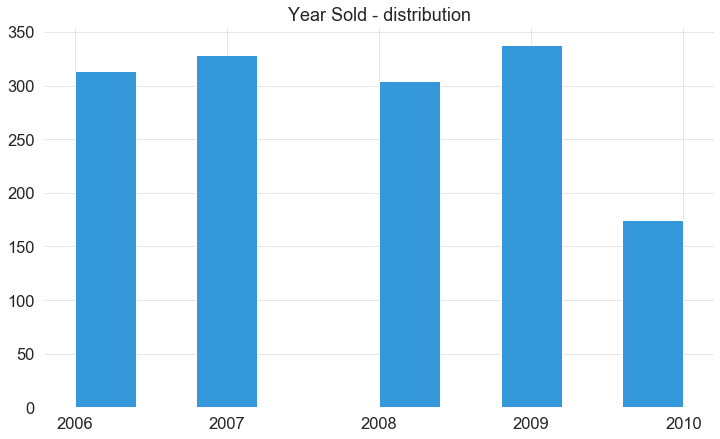

In [463]:
plt.hist(df_train.YrSold);
plt.xticks(df_train.YrSold.unique().tolist());
plt.title("Year Sold - distribution");

<h3 style='background-color:yellow'>
Discrete variable.<br>
Around 300 number of sales happened in year 2006 to 2009. <br>    
2010 has less selling happened. <br>
</h3>

### 76. SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

Value counts: 

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64
Null value count :  0


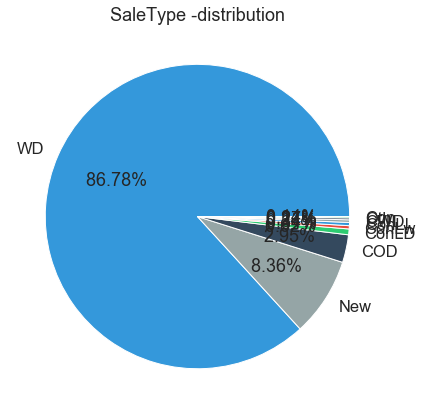

In [464]:
str_discrete_analysis(df_train.SaleType)

<h3 style='background-color:yellow'>Discrete variable. <br>
Most of the sales are Warranty Deed -Conventional </h3>

### 77. SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

In [465]:
df_train.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

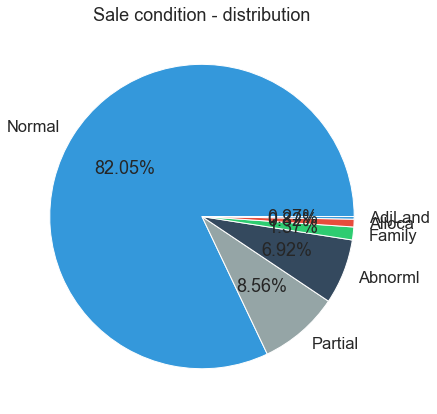

In [466]:
plt.pie(df_train.SaleCondition.value_counts(),autopct=lambda s: f'{s:.2f}%',labels=df_train.SaleCondition.value_counts().index);
plt.title("Sale condition - distribution");

<h3 style='background-color:yellow'>
Categorical String variable.<br>
Most Sale are 'Normal'
</h3>

### 78. HouseStyle
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

Value counts: 

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64
Null value count :  0


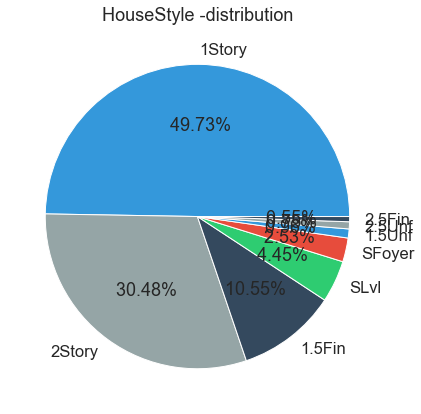

In [467]:
str_discrete_analysis(df_train.HouseStyle)

<h3 style='background-color:yellow'> 
String discrete variable
</h3>

## <center>Feature Relationships</center>

### 1. Sale price based on the Neighborhood

In [468]:
grp_neighbrhd=df_train.groupby("Neighborhood")

In [469]:
unique_neighbrhd=df_train.Neighborhood.unique().tolist()

In [470]:
neighbrhd_list, SalePrice_list = [],[]
for item in unique_neighbrhd:
    df = grp_neighbrhd.get_group(item)
    neighbrhd_list.append(item)
    SalePrice_list.append(df.SalePrice.mean())

In [471]:
df_neighbrhd=pd.DataFrame({"Neighborhood": neighbrhd_list,
                          "SalePrice": SalePrice_list})
df_neighbrhd.sort_values("SalePrice",ascending=False,inplace=True)

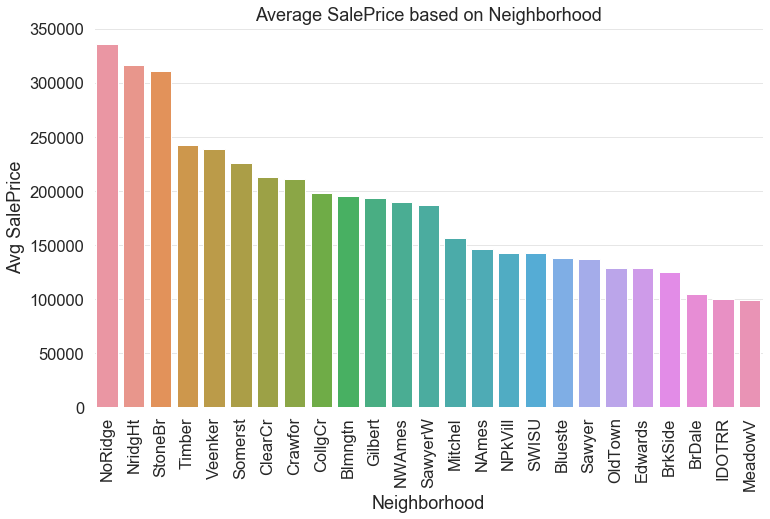

In [472]:
sns.barplot(data=df_neighbrhd,x="Neighborhood",y="SalePrice");
plt.xticks(rotation=90);
plt.ylabel("Avg SalePrice");
plt.title("Average SalePrice based on Neighborhood");

In [473]:
del([grp_neighbrhd,df_neighbrhd,df,unique_neighbrhd])

<h3 style='background-color:yellow'>
Houses in Northridge got highest average saleprice.<br>
And Meadow Village got the least average saleprice.
</h3>

### 2. OverAll quality of the house and SalePrice

In [474]:
grp_overallqual=df_train.groupby("OverallQual")
unique_overallqual=df_train.OverallQual.unique()
sale_price_list,overall_qual=[],[]
for item in unique_overallqual:
    df=grp_overallqual.get_group(item)
    overall_qual.append(item)
    sale_price_list.append(df.SalePrice.mean())
df_overallqual=pd.DataFrame({"OverallQual":overall_qual,
                            "SalePrice": sale_price_list})

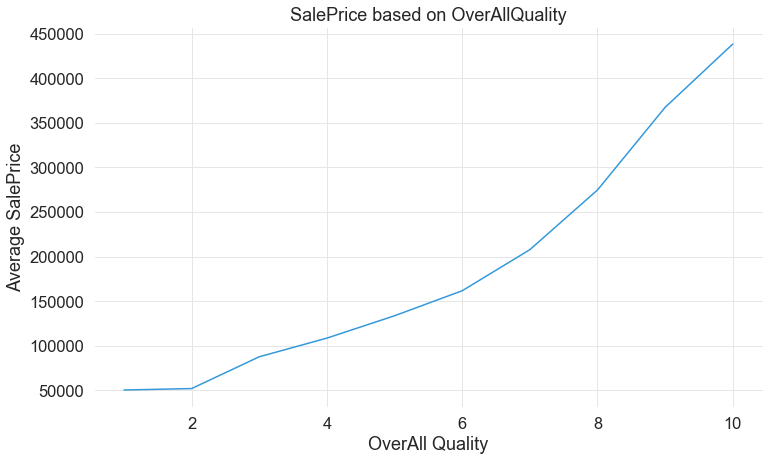

In [475]:
sns.lineplot(data=df_overallqual,x="OverallQual",y="SalePrice");
plt.title("SalePrice based on OverAllQuality");
plt.ylabel("Average SalePrice");
plt.xlabel("OverAll Quality");

<h3 style='background-color:yellow'>
It's clear from the dataset that As the quality of the house increases, Saleprice also increases.
</h3>

In [476]:
del(df,df_overallqual)

### 3. Age of the house and SalePrice

In [477]:
df=df_train.loc[:,["YearBuilt","YrSold","SalePrice"]].copy()

In [478]:
df["Age"]=df.YrSold-df.YearBuilt

In [479]:
print ("House age statistics:\n")
df.Age.describe()

House age statistics:



count    1460.000000
mean       36.547945
std        30.250152
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: Age, dtype: float64

In [480]:
grp_age=df.groupby("Age")
unique_age=df.Age.unique()
age_list,sale_price_list,count_list=[],[],[]
for age in unique_age:
    df_sale=grp_age.get_group(age)
    age_list.append(age)
    sale_price_list.append(df_sale.SalePrice.mean())
    count_list.append(df_sale.Age.count())

In [481]:
df_sale=pd.DataFrame({"Age": age_list,
                     "SalePrice": sale_price_list,
                     "Count":count_list})

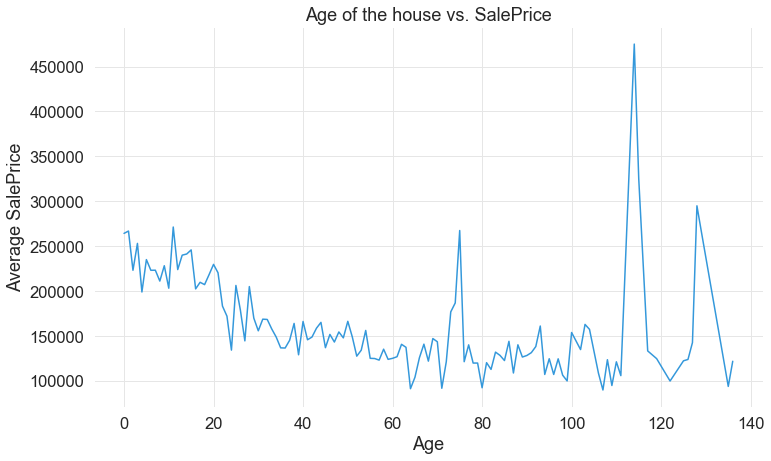

In [482]:
sns.lineplot(data=df_sale,x="Age",y="SalePrice");
plt.title("Age of the house vs. SalePrice");
plt.ylabel("Average SalePrice");


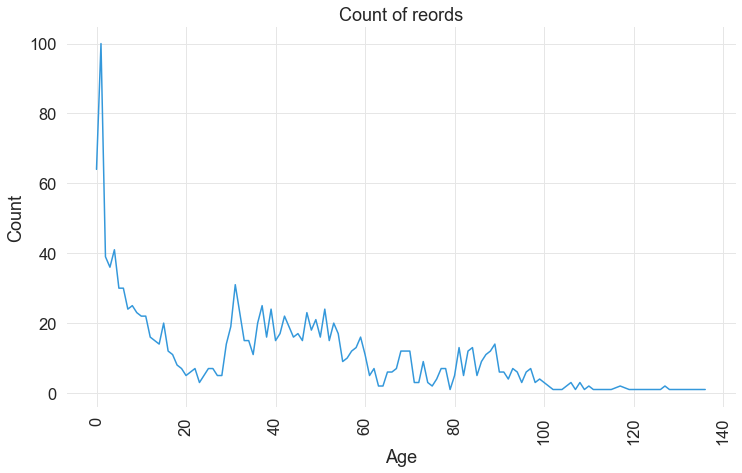

In [483]:
sns.lineplot(data=df_sale,x="Age",y="Count");
plt.xticks(rotation=90);
plt.title("Count of reords");

<h3 style='background-color:yellow'> 
Maximum age of the houses in the dataset is 136.<br>    
    There are 100 number of newly constructed houses are there. <br>
Average SalePrice decreases as the age of the house increases.
<br>
However there is a sudden increae on the price for the houses whose age is 114.
</h3>

## <center> Data Imputation </center>

In [484]:
df_input=df_train.copy()

In [485]:
def process_imputation(df_input):
    df_input["PoolQC"].fillna("NA",inplace=True)
    print ("PoolQC - replaced missing values with NA")
    df_input.MiscFeature.fillna("NA",inplace=True)
    print ("MiscFeature - replaced missing values with NA")
    df_input.Alley.fillna("NA",inplace=True)
    print ("Alley - replaced missing values with NA")
    df_input.Fence.fillna('NA',inplace=True)
    print ("Fence - replaced missing values with NA")
    df_input.FireplaceQu.fillna("NA",inplace=True)
    print ("FireplaceQuality - replaced missing values with NA")
    df_input.LotFrontage.fillna(0,inplace=True)
    print ("Lot frontage - replaced missing values with zero")
    df_input.GarageType.fillna("NA",inplace=True)
    print ("Garage type - replaced missing values with NA")
    print ("GarageYrBlt - Replacing missing value with House built year")
    df_input.GarageYrBlt.fillna(df_input.YearBuilt,inplace=True)
    print ("GarageFinish - Replacing missing values with NA")
    df_input.GarageFinish.fillna('NA',inplace=True)
    print ("GarageQual - Replacing missing values with NA")
    df_input.GarageQual.fillna('NA',inplace=True)
    print ("GarageCond - Replacing missing values with NA")
    df_input.GarageCond.fillna('NA',inplace=True)
    for col in ["BsmtExposure","BsmtFinType2","BsmtFinType1","BsmtCond","BsmtQual"]:
        df_input[col].fillna("NA", inplace=True)
    print (f"{col} - replaced missing values with NA")
    df_input.MasVnrArea.fillna(0,inplace=True)
    print ("MasVnrArea - replaced missing values with 0")
    df_input.MasVnrType.fillna("None",inplace=True)
    print ("MasVnrType - replaced missing values with None")
    df_input.Electrical.fillna("NA",inplace=True)
    print ("Electrical - replaced missing values with NA")
    print ("Is there any missing values? ")
    print (df_input.isnull().any().value_counts().index)
    return df_input

In [486]:
df_input=process_imputation(df_input)

PoolQC - replaced missing values with NA
MiscFeature - replaced missing values with NA
Alley - replaced missing values with NA
Fence - replaced missing values with NA
FireplaceQuality - replaced missing values with NA
Lot frontage - replaced missing values with zero
Garage type - replaced missing values with NA
GarageYrBlt - Replacing missing value with House built year
GarageFinish - Replacing missing values with NA
GarageQual - Replacing missing values with NA
GarageCond - Replacing missing values with NA
BsmtQual - replaced missing values with NA
MasVnrArea - replaced missing values with 0
MasVnrType - replaced missing values with None
Electrical - replaced missing values with NA
Is there any missing values? 
Index([False], dtype='object')


<h3 style='background-color:yellow'> 
    Missing values removed from dataset.
    </h3>

## <center> Data cleaning,manipulation </center>

In [487]:
print (f"Target variable SalepPrice skewness: {df_input.SalePrice.skew()}")

Target variable SalepPrice skewness: 1.8828757597682129


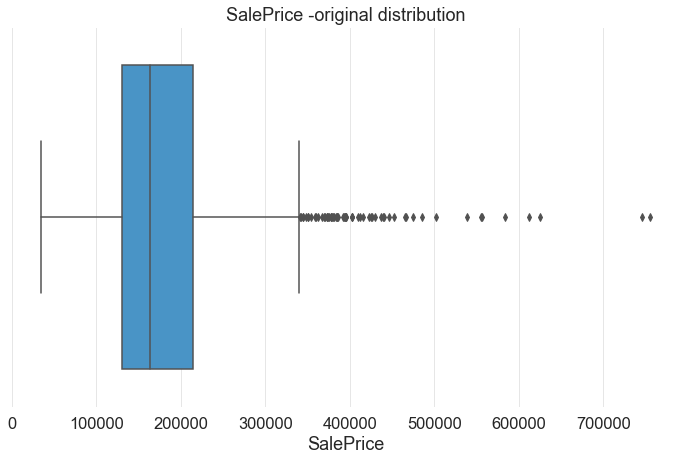

In [488]:
sns.boxplot(data=df_input,x="SalePrice")
plt.title("SalePrice -original distribution");

In [489]:
total = df_input.shape[0]
threshold_price=330000
cnt=df_input.query("SalePrice > @threshold_price").shape[0]
print ("Target variable having outliers. Let's find how many records are there after", threshold_price, " :",cnt, " which is " ,(cnt/total)*100, "%")

Target variable having outliers. Let's find how many records are there after 330000  : 71  which is  4.863013698630137 %


In [490]:
# print ("Removing records with SalePrice > ", threshold_price)
# df_input.drop(df_input[df_input["SalePrice"]>threshold_price].index,inplace=True)

In [491]:
# plt.subplot(2,2,1)
# sns.boxplot(data=df_input,x="SalePrice")
# plt.suptitle("SalePrice -Ater removing outliers distribution");
# plt.subplot(2,2,2)
# plt.hist(data=df_input,x="SalePrice");
print ("Skewness",df_input.SalePrice.skew())

Skewness 1.8828757597682129


Applying SquareRoot method of Saleprice for reducing the skewness.
Skewness:  0.9431527373310963


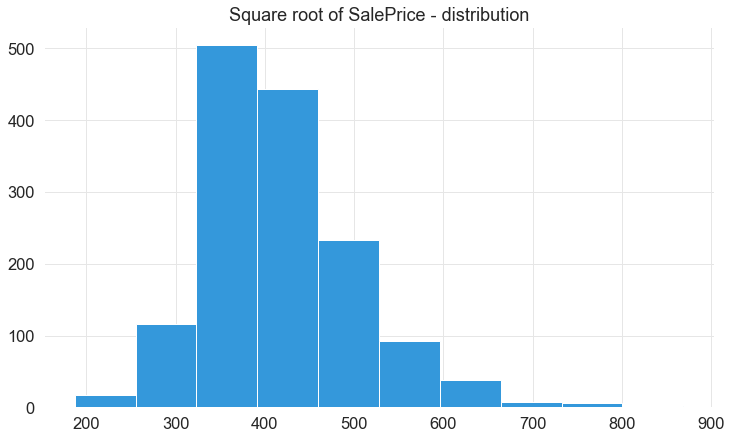

In [492]:
print ("Applying SquareRoot method of Saleprice for reducing the skewness.")
df_input["SalePrice_sqrt"] =np.sqrt(df_input.SalePrice)
plt.hist(df_input.SalePrice_sqrt);
plt.title("Square root of SalePrice - distribution");
print ("Skewness: ", df_input.SalePrice_sqrt.skew());

In [493]:
def wrangle_data(df):
    print (f"Shape of the dataframe before wrangling: {df.shape}")
    #Create new feature Age from year built and year sold
    df["Age"]=df["YrSold"] - df["YearBuilt"]
    print ("Created new feature 'Age' using Year sold and Year built")
    df.drop(["YearBuilt","YrSold"],axis=1,inplace=True)
    print ("Removed features - YearBuilt,YrSold")
        
    #Below features contains meaningless value or presence of one value dominant.
    #Hence This features doesn't make any sense.So removing from dataset.
    del_vars=["Street","Alley","LandContour","Utilities","LandSlope","Condition2","RoofMatl","Heating","CentralAir","Electrical",
         "Functional","MiscFeature","MoSold","Id"]
    df.drop(del_vars,inplace=True,axis=1)
    
    ordinal_vars=["BsmtQual","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
                 "GarageCars","Age"]
    lbl_encoder=LabelEncoder()
    for var in ordinal_vars:
        df[var]=lbl_encoder.fit_transform(df[var])
        
    for var in ["BsmtFinType1","BsmtFinType2"]:
        df[var].replace(["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],[0,1,2,3,4,5,6],inplace=True)
        
    for var in ["ExterQual","ExterCond","BsmtCond","HeatingQC","KitchenQual","FireplaceQu","GarageQual","GarageCond","PoolQC"]:
        df[var].replace(["Ex","Gd","TA","Fa","Po","NA"],[0,1,2,3,4,5],inplace=True)
        
    for var in ["BsmtExposure"]:
        df[var].replace(["Gd","Av","Mn","No","NA"],[0,1,2,3,4],inplace=True)
        
    for var in ["GarageFinish"]:
        df[var].replace(["Fin","RFn","Unf","NA"],[0,1,2,3],inplace=True)
        
    for var in ["PavedDrive"]:
        df[var].replace(["Y","P","N"],[0,1,2],inplace=True)
    
    for var in ["Fence"]:
        df[var].replace(["GdPrv","MnPrv","GdWo","MnWw","NA"],[0,1,2,3,4],inplace=True)    
    df=pd.get_dummies(df)
    print (f"Shape of the dataframe after wrangling {df.shape}")
    return df

In [494]:
df_input=wrangle_data(df_input)

Shape of the dataframe before wrangling: (1460, 82)
Created new feature 'Age' using Year sold and Year built
Removed features - YearBuilt,YrSold
Shape of the dataframe after wrangling (1460, 182)


In [495]:
df_input.drop("SalePrice",axis=1,inplace=True)
print ("Removed the feature SalePrice")

Removed the feature SalePrice


In [496]:
#Checking for any String fields.
print("List of any string data?")
df_input.dtypes[df_input.dtypes=="object"]

List of any string data?


Series([], dtype: object)

In [497]:
corr_matrix=df_input.corr()

In [498]:
corr_matrix=pd.DataFrame(corr_matrix['SalePrice_sqrt']).sort_values('SalePrice_sqrt',ascending=False)

In [499]:
negative_corr_flds=corr_matrix[corr_matrix["SalePrice_sqrt"]< 0].index.tolist()

In [500]:
#Remove negative correlated features
df_input.drop(negative_corr_flds,axis=1,inplace=True)

In [501]:
#Removing below derived features from dataset, since they are not present in the final test file.
df_input.drop(["HouseStyle_2.5Fin","Exterior1st_ImStucc","Exterior1st_Stone","Exterior2nd_Other"],axis=1,inplace=True)

In [502]:
#Create independent and dependent features for model training.
x=df_input.drop('SalePrice_sqrt',axis=1)
y=df_input.SalePrice_sqrt
training_features=x.columns.tolist()

In [503]:
#Training and Testing split.
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)
print (f"Shape of x train: {x_train.shape}, y train: {y_train.shape},x test: {x_test.shape}, y test: {y_test.shape}")

Shape of x train: (1095, 78), y train: (1095,),x test: (365, 78), y test: (365,)


## <center> Model Evaluation </center>

In [504]:
#Function for providing generalized results for regression model
def evaluate_model(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    print (f"Training score: {model.score(x_train,y_train)} \nTesting score: {model.score(x_test,y_test)}")
    y_pred=model.predict(x_test)
    print("Prediction completed")
    df=pd.DataFrame({"Actual": y_test,
                     "Predicted":y_pred})
    #Applying square function to transform to original target variable.
    df=df.apply(np.square)
    #Finding the difference between original and predicted
    df["difference"]=df.Predicted-df.Actual
    df.reset_index(inplace=True)
    #Plot actual vs predicted
    plt.figure(figsize=(20,10));
    sns.scatterplot(data=df,x="index",y="Actual",color='lightgrey',label=["Actual"]);
    sns.lineplot(data=df,x="index",y="Predicted",color='red',label=["Predicted"]);
    plt.legend(loc="right",bbox_to_anchor=(1.1,1));
    plt.title("Actual vs Predicted");
    plt.show()
    return model
    

### Model: LinearRegression

Training score: 0.8811094128582516 
Testing score: 0.8871636064844666
Prediction completed


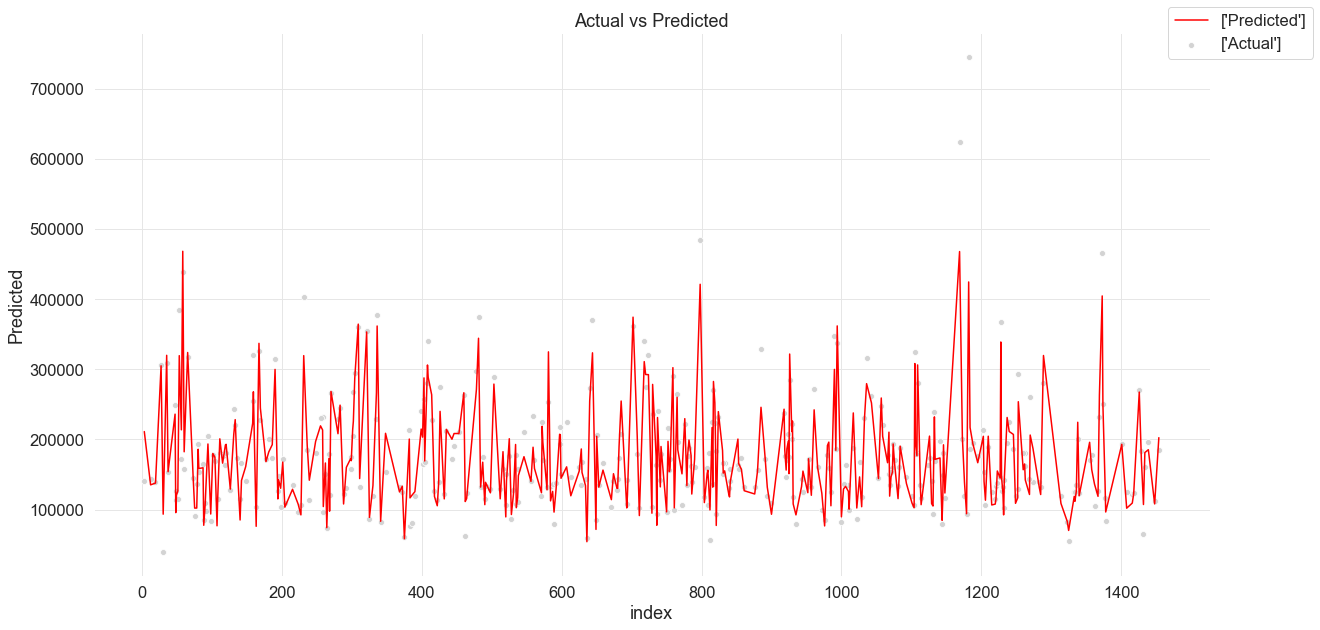

In [505]:
lr_model=evaluate_model(LinearRegression(normalize=True),x_train,y_train,x_test,y_test)

### Model: Lasso Regression

Training score: 0.8793629263950989 
Testing score: 0.8917226700231269
Prediction completed


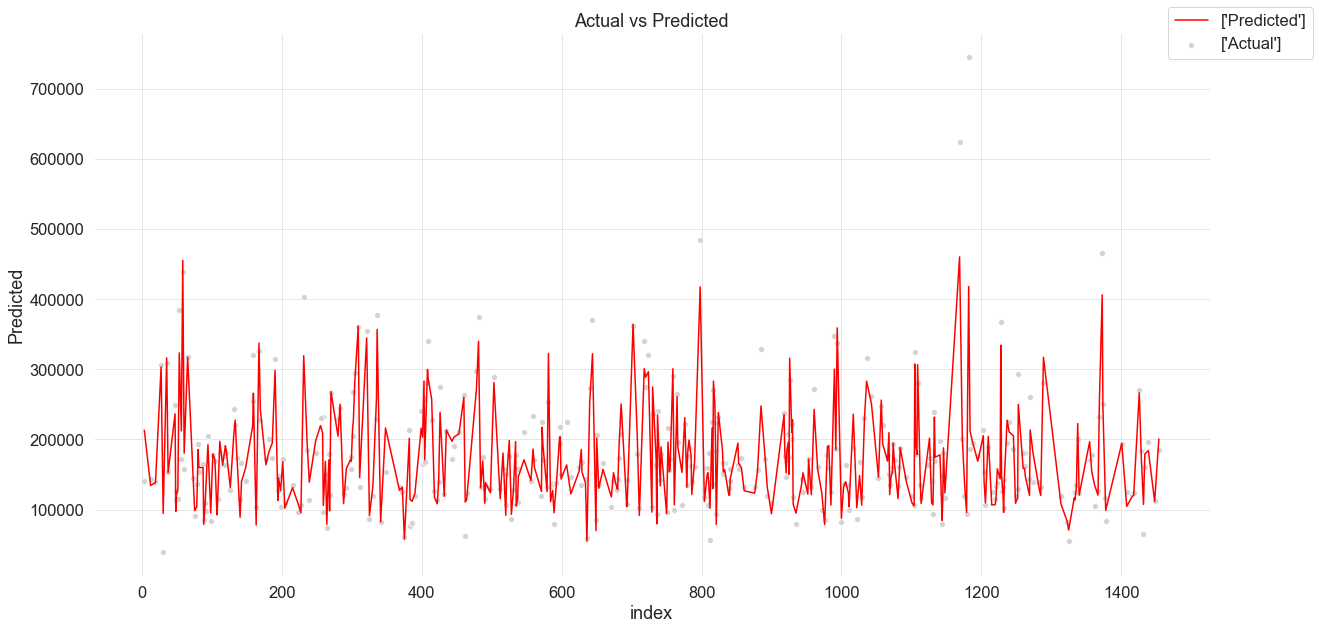

In [506]:
lasso_reg=evaluate_model(Lasso(alpha=.01,normalize=True),x_train,y_train,x_test,y_test)

### Model: Ridge Regression

Training score: 0.8470124822994657 
Testing score: 0.8666142201304858
Prediction completed


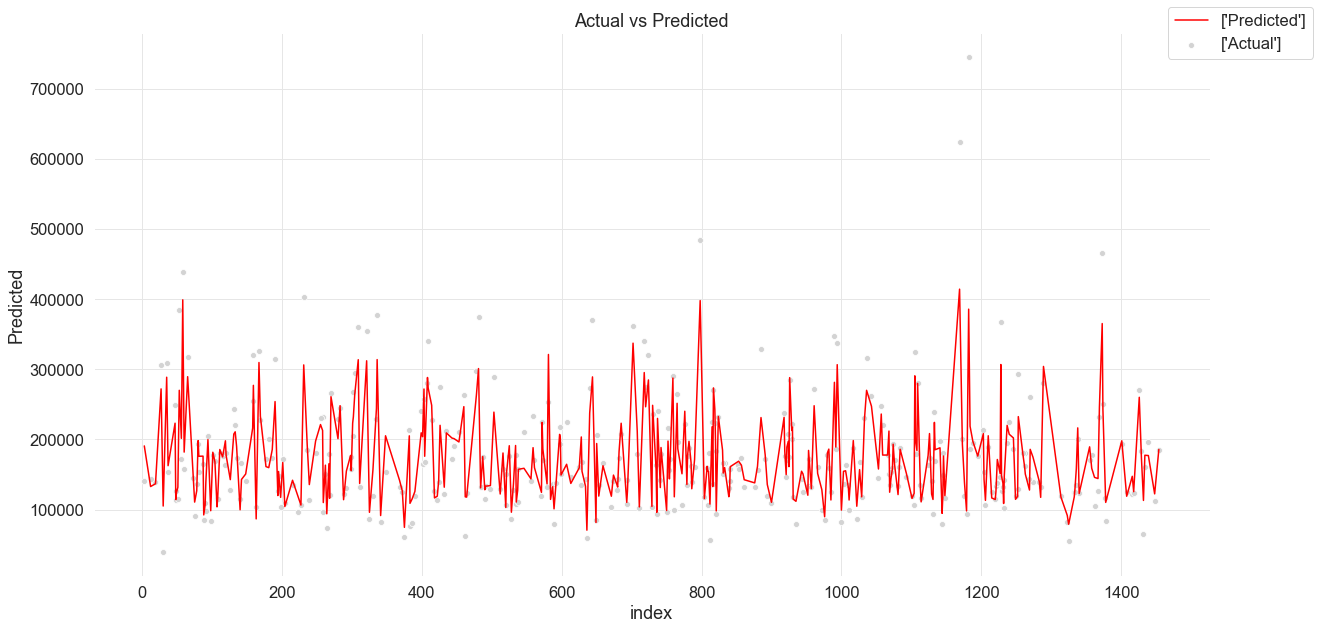

In [507]:
ridge_reg=evaluate_model(Ridge(normalize=True),x_train,y_train,x_test,y_test)

### Model: ElasticNet Regression

Training score: 0.8223215688775494 
Testing score: 0.8660793591694105
Prediction completed


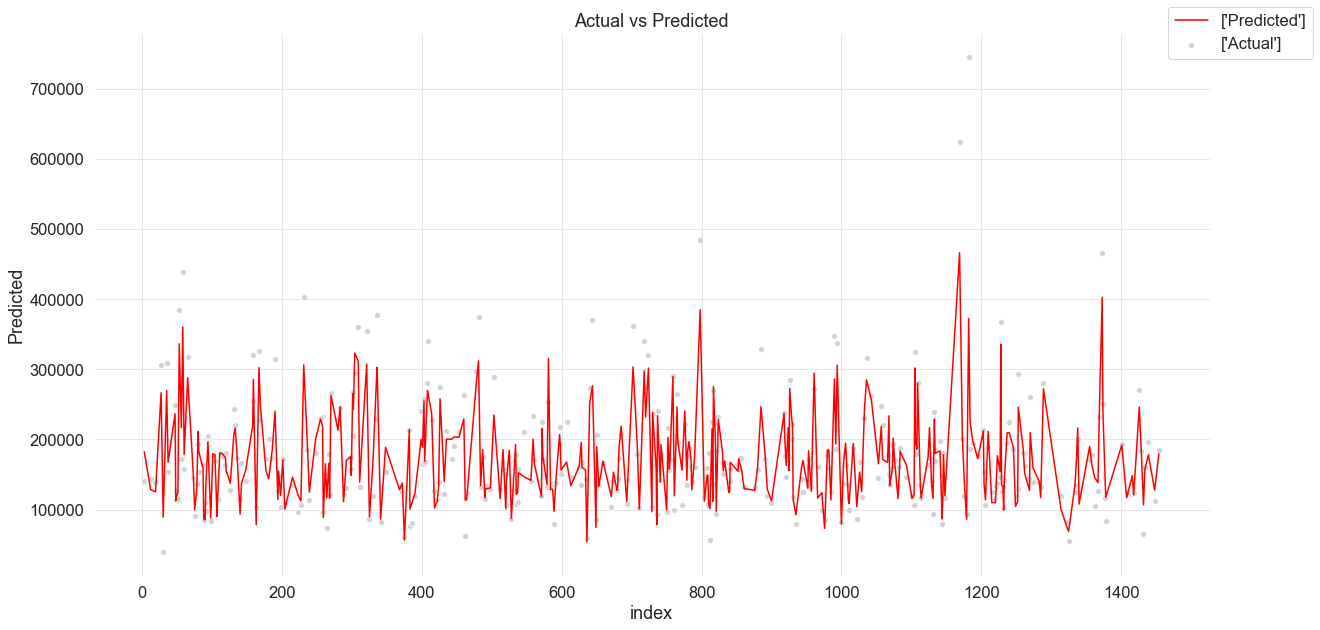

In [508]:
el=evaluate_model(ElasticNet(normalize=False),x_train,y_train,x_test,y_test)

### Model: XtremeGradientBoosting

Training score: 0.9996047852357992 
Testing score: 0.8764707650918724
Prediction completed


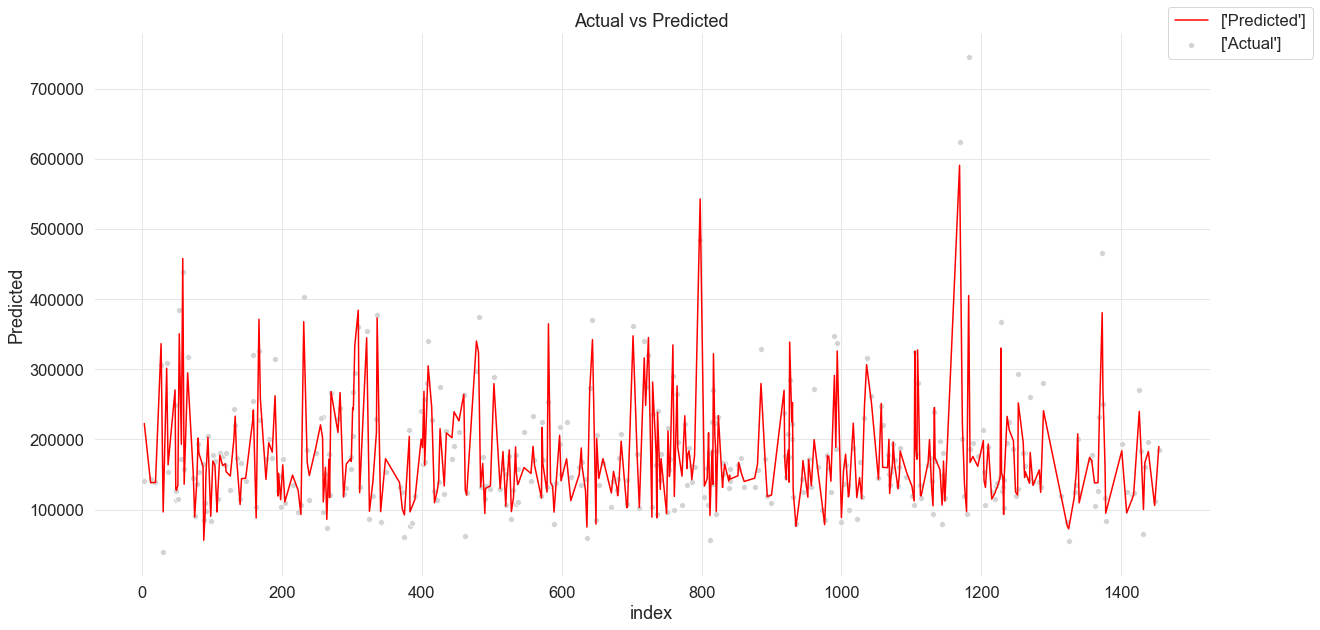

In [509]:
xgb_reg=evaluate_model(XGBRegressor(),x_train,y_train,x_test,y_test)

In [510]:
del(df,df_input,df_sale,df_train)

## <center> Test file output prediction</center>

In [559]:
df_test=pd.read_csv("test.csv")

In [560]:
df_input=df_test.copy()

In [561]:
print ("Shape of test data: ",df_input.shape)

Shape of test data:  (1459, 80)


In [562]:
df_input=process_imputation(df_input)

PoolQC - replaced missing values with NA
MiscFeature - replaced missing values with NA
Alley - replaced missing values with NA
Fence - replaced missing values with NA
FireplaceQuality - replaced missing values with NA
Lot frontage - replaced missing values with zero
Garage type - replaced missing values with NA
GarageYrBlt - Replacing missing value with House built year
GarageFinish - Replacing missing values with NA
GarageQual - Replacing missing values with NA
GarageCond - Replacing missing values with NA
BsmtQual - replaced missing values with NA
MasVnrArea - replaced missing values with 0
MasVnrType - replaced missing values with None
Electrical - replaced missing values with NA
Is there any missing values? 
Index([False, True], dtype='object')


In [563]:
val=df_input.isnull().sum()
df=pd.DataFrame(val,columns=["NullCount"]).query('NullCount != 0')
df=pd.DataFrame({"Features": df.index,
             "NullCount": df.NullCount.values})
df.sort_values(by="NullCount",inplace=True,ascending=False)
print("Fields with missing values:\n",df)

Fields with missing values:
         Features  NullCount
0       MSZoning          4
1      Utilities          2
8   BsmtFullBath          2
9   BsmtHalfBath          2
11    Functional          2
2    Exterior1st          1
3    Exterior2nd          1
4     BsmtFinSF1          1
5     BsmtFinSF2          1
6      BsmtUnfSF          1
7    TotalBsmtSF          1
10   KitchenQual          1
12    GarageCars          1
13    GarageArea          1
14      SaleType          1


In [564]:
for col in ["MSZoning","Utilities","Functional","Exterior1st","Exterior2nd","KitchenQual","SaleType"]:
    df_input[col].fillna("NA",inplace=True)
    print (col,"Replaced missing values with NA")
for col in ["BsmtFullBath","BsmtHalfBath","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","GarageCars","GarageArea"]:
    df_input[col].fillna(0,inplace=True)
    print (col,"Replaced missing values with 0")

MSZoning Replaced missing values with NA
Utilities Replaced missing values with NA
Functional Replaced missing values with NA
Exterior1st Replaced missing values with NA
Exterior2nd Replaced missing values with NA
KitchenQual Replaced missing values with NA
SaleType Replaced missing values with NA
BsmtFullBath Replaced missing values with 0
BsmtHalfBath Replaced missing values with 0
BsmtFinSF1 Replaced missing values with 0
BsmtFinSF2 Replaced missing values with 0
BsmtUnfSF Replaced missing values with 0
TotalBsmtSF Replaced missing values with 0
GarageCars Replaced missing values with 0
GarageArea Replaced missing values with 0


In [565]:
val=df_input.isnull().sum()
df=pd.DataFrame(val,columns=["NullCount"]).query('NullCount != 0')
df=pd.DataFrame({"Features": df.index,
             "NullCount": df.NullCount.values})
df.sort_values(by="NullCount",inplace=True,ascending=False)
print("Fields with missing values:\n",df)

Fields with missing values:
 Empty DataFrame
Columns: [Features, NullCount]
Index: []


In [567]:
df_result=pd.DataFrame()
df_result["Id"]=df_input.Id

In [568]:
df_input=wrangle_data(df_input)

Shape of the dataframe before wrangling: (1459, 80)
Created new feature 'Age' using Year sold and Year built
Removed features - YearBuilt,YrSold
Shape of the dataframe after wrangling (1459, 180)


In [569]:
print ("Any string features: ")
#Checking for any String fields.
df_input.dtypes[df_input.dtypes=="object"]

Any string features: 


Series([], dtype: object)

In [570]:
#Remove negative correlated features
df_input.drop(negative_corr_flds,axis=1,inplace=True)

In [571]:
test_features=df_input.columns

In [572]:
print ("Columns Not present in test_features: \n")
for x in training_features:
    if x not in test_features:
        print (x)
print ("\nColumns Not present in train_features:\n")
for x in test_features:
    if x not in training_features:
        print (x)       

Columns Not present in test_features: 


Columns Not present in train_features:

MSZoning_NA
Exterior1st_NA
Exterior2nd_NA
SaleType_NA


In [573]:
#Removing below unwanted columns
df_input.drop(["Exterior1st_NA", "MSZoning_NA", "SaleType_NA", "Exterior2nd_NA"
              ],axis=1,inplace=True)

In [574]:
x=df_input
y_predict=lasso_reg.predict(x)
y_predict=np.square(y_predict)

In [578]:
df_result["SalePrice"]=pd.Series(y_predict.tolist())

In [579]:
df_result

,Id,SalePrice
0,1461,102303.809044
1,1462,150365.992309
2,1463,168217.642146
3,1464,185564.418207
4,1465,220160.118682
...,...,...
1454,2915,71817.799528
1455,2916,83024.384001
1456,2917,171986.030822
1457,2918,108993.389985


In [582]:
print ("Exporting predicted results")
df_result.to_csv("predict_result.csv",index=False)

Exporting predicted results
